In [1]:
from WeightsProperties import *
from CaffeVPLUtils import *
from scipy.stats import f_oneway, ttest_ind, ttest_rel, kruskal, kstest, ks_2samp, \
mannwhitneyu, chi2_contingency,chisquare, skew, wilcoxon
%matplotlib inline
from scipy.stats import pearsonr, sem, spearmanr
from scipy import misc
from statsmodels.formula.api import ols
import statsmodels.api as sm
import tqdm
panel_font = dict(fontsize=18, fontweight=3)
plt.rc('text', usetex=False)

import seaborn.apionly as sns
from IPython.core.display import SVG, display
import svgutils.compose as sg

from matplotlib import rc
fig_dir = 'figs/'
panel_font = dict(fontsize=15, fontweight=3)
plt.rc('font',family='Times')
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['font.size'] = 18
#plt.rc('text', usetex=True)
rc('mathtext', default='regular') 
plt.rcParams['axes.axisbelow']=True

C:\Anaconda64\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def correlate_two(ax, f1, f2, **kwargs):
    
    f1 = f1/(np.abs(f1).max())
    f2 = f2/(np.abs(f2).max())

    ax.scatter(f1, f2, **kwargs)
    cor, p = pearsonr(f1,f2)
    if np.all(f1>=0) :
        ax.set_xlim([0, 1.2])
    else:
        ax.set_xlim([-1,1.2])
    if np.all(f2>=0):
        ax.set_ylim([0, 1.2])
    else:
        ax.set_ylim([-1,1.2])
        
    ptext = r'%.2f,%.2g' % (cor, p)
    if p<0.00001:
        ptext = r'%.2f,<$10^{-5}$' % (cor)
    ax.text(0.05,1.1, ptext, 
            horizontalalignment='left',
            verticalalignment='top',
           transform=ax.transAxes)


def plot_env(ax, x, y_mean, y_std = None, color='k', label=None, std_scale = 1, alpha = 1.0, **kwargs):
    '''
    plot an envelope
    '''
    if y_std is None:
        assert y_mean.ndim == 2
        y_std = y_mean.std(1)
        y_mean = y_mean.mean(1)
    else:
        assert y_mean.ndim == 1
        assert y_std.ndim == 1


    ax.plot(x, y_mean, label=label, color = color, alpha = alpha, **kwargs)

    ax.fill_between(x, 
             y_mean - y_std/std_scale,
             y_mean + y_std/std_scale, 
             color=color, alpha = 0.5*alpha)
    
def lookup(df_in, **kwargs):
    
    df = df_in.copy()
    for k, v in kwargs.items():
        df = df[np.abs(df[k]-v)<0.001]
    return df, df.index.tolist()
    
    

def scatter_errorbar(ax, x, y, bins, plot = True, **kwargs):

    count, _ = np.histogram(x, bins=bins)
    bin_idx = np.digitize(x, bins)-1
    bin_centers = (bins[1:]+bins[:-1])/2.0

    bin_vals = [y[bin_idx == i] for i in range(len(bins)-1)]
    
    means = np.array(map(np.mean, bin_vals))
    sems  = np.array(map(sem, bin_vals))
    
    means[np.isnan(means)] = 0.0
    sems[np.isnan(sems)] = 0.0
    if plot:
        ax.errorbar(bin_centers, means, sems, **kwargs)
    
    return means, sems, bin_vals



In [3]:
np.diag(np.diag(np.random.rand(3,3)))

array([[ 0.78849767,  0.        ,  0.        ],
       [ 0.        ,  0.16655533,  0.        ],
       [ 0.        ,  0.        ,  0.30121213]])

In [4]:
weights_dir = 'models/'
tuning_dir  = 'data/tuning'
var_param_name = 'd_angle'

sense_measures = dict()
sense_measures['mean']          = lambda r_mean, r_var, r_grad, r_cov: r_mean
sense_measures['n_mean']          = lambda r_mean, r_var, r_grad, r_cov: r_mean/r_mean.max(0)[None,:]
sense_measures['var']           = lambda r_mean, r_var, r_grad, r_cov: r_var
sense_measures['std']           = lambda r_mean, r_var, r_grad, r_cov: np.sqrt(r_var)
sense_measures['grad']          = lambda r_mean, r_var, r_grad, r_cov: r_grad
sense_measures['mean_var']          = lambda r_mean, r_var, r_grad, r_cov: r_mean/(1e-4+r_var)
sense_measures['abs_grad']      = lambda r_mean, r_var, r_grad, r_cov: np.abs(r_grad)
sense_measures['abs_grad_std']      = lambda r_mean, r_var, r_grad, r_cov: np.abs(r_grad)/np.sqrt(r_var)
sense_measures['grad2_var']      = lambda r_mean, r_var, r_grad, r_cov: (r_grad)**2/(r_var)

def lfi(r_mean, r_var, r_grad, r_cov):
    
    out = np.zeros(r_mean.shape[0])
    
    for i in range(r_mean.shape[0]):
        greater = r_mean[i]>1.0
        m = r_grad[i][greater]
        c = r_cov[i][np.ix_(greater, greater)]
        out[i] = m.dot(np.dot(np.linalg.inv(c), m))/sum(greater)
    return out

sense_measures['lfi']           = lambda r_mean, r_var, r_grad, r_cov: lfi(r_mean, r_var, r_grad, r_cov)

weights_file = "A_angle_d_angle_['angle', 'wave']_[10.0,0.5,-5.0]_15_[*.0_10.0_0.2]_[0.0_0.0]_20_0.0001_0.9_0.0_0_1000_6"

w_df = load_weights_df(weights_file,tuning_dir,var_param_name)
diff_values = np.sort(w_df['d_angle'].unique())
len(w_df)

figs_dir = os.path.join('figs', 'real2')
results_dir = os.path.join('results', 'real2')


In [5]:
w_df.iloc[0].w_file

"data/tuning/A_angle_d_angle_['angle', 'wave']_[10.0,0.5,-5.0]_15_[0.0_10.0_0.2]_[0.0_0.0]_20_0.0001_0.9_0.0_0_1000_6_07-20-22-36-51_0.5_iter_1000.tuning"

In [6]:
dfs = []
qfs = []
for wf in tqdm.tqdm(w_df['w_file']):
    
    tf = TuningFeatures(wf, full_cov=True)
    tf.load_tuning()
    tf.compute_features(sense_measures, smoothing = 1)
    noise = tf.attrs['noise']
    angle = tf.attrs['angle']
    wave = tf.attrs['wave']
    ctrst = tf.attrs['ctrst']
    tf.measure_test(angle,1)
    
    wf0 = "models/AlexNet/weights_1c.caffemodel"
    tf0 = TuningFeatures(wf0, noise = noise, angle = angle, ctrst = ctrst, wave = wave, full_cov=True)
    tf0.load_tuning()
    tf0.compute_features(sense_measures, smoothing = 1)
    tf0.measure_test(angle,1)
        
    df = tf-tf0

    dfs.append(df)
    tf.raw_tc.close()
    tf0.raw_tc.close()

100%|█████████████████████████████████████████████████████████████████████| 60/60 [01:31<00:00,  1.31s/it]


In [7]:
nangle = 100
angles = np.linspace(-90.0,90.0,nangle)
blobs = ['norm1','norm2','conv3','conv4','conv5']
nblob = len(blobs)
diffs = np.sort(w_df.d_angle.unique())
ndiff = len(diffs)

In [8]:
len(dfs)

60

In [9]:
def load_df(res_names, s):
    
    files = get_results_files(s)
    results = dict()
    
    for this_file in files:
        
        with open(os.path.join(results_dir,this_file), 'r') as f:
            
            res = pkl.load(f)
            attrs = parse_filename(res['filename'])
            var_param_name = attrs['var_param_name']
            
            for pi, p in enumerate(res['params']):   
                # inserting results from file content
                for name in res_names:
                    results.setdefault(name, [])
                    # the following results have an extra dimension of var_param_name
                    if name in ['accs','losses','dps','n_accs','dws','n_dps']:
                        results[name].append(res[name][pi])
                    else:
                        results[name].append(res[name])
                # inserting results from file name
                for attr in attrs:
                    results.setdefault(attr, [])

                    results[attr].append(attrs[attr])
                
                # attributes that changes (var_param_name) should be corrected
                results.setdefault('start_layer', [])
                if var_param_name == 'layer':
                    results['start_layer'].append(p)
                else:
                    results[var_param_name][-1] = p
                    results['start_layer'].append(p)
    return pd.DataFrame(results)
    
def get_results_files(s):
    
    s = s.replace('[','?')
    s = s.replace(']','?')
    s = s.replace("'","?")
    s = s.replace(",","?")
    
    if '.pdf' in s:
        s = s[0:-18]
    elif '-' in s[-15:]:
        s = s[0:-15]
    
    s = '*' + s + '*'
    files = [os.path.join(f[0], f1) for f in os.walk(figs_dir) for f1 in f[2]]

    files = fnmatch.filter(files, s)
    files = [os.path.basename(f)[:-4]+'.results' for f in files]
    return files
                
def parse_filename(fn):
    
    file_attr = dict()
    attrs = fn.split('_')
    attrs = [s.translate(None, '[]') for s in attrs]

    if 'morph' not in fn:

        # merge d_angle
        if 'd' in attrs:
            d_idx = attrs.index('d')
            attrs[d_idx] += '_'+attrs[d_idx+1]
            del attrs[d_idx+1]
            
        file_attr['var_param_name'] = attrs[2]

        file_attr['network'] = attrs[5]
        file_attr['train_feat'] = attrs[1]
        file_attr['noise'] = float(attrs[5])
        file_attr['angle'] = float(attrs[6])
        file_attr['wave'] = float(attrs[7])
        file_attr['ctrst'] = float(attrs[8])

        file_attr['d_angle'] = float(attrs[9])
        file_attr['d_wave'] = float(attrs[10])
        
        file_attr['batch_size'] = int(attrs[11])
        file_attr['base_lr'] = float(attrs[12])
        file_attr['momentum'] = float(attrs[13])
        file_attr['weight_decay'] = float(attrs[14])
        file_attr['niter']  = int(attrs[16])
        file_attr['version']  = int(attrs[17])
    else:
        "A_morph_1_127_layer_[0.0,5.0,1.0]_20_0.2_20_0.0001_0_1000_6_03-29-10-52-45"
        file_attr['var_param_name'] = attrs[4]
        file_attr['level'] = int(attrs[2])
        file_attr['dset'] = int(attrs[3])
        file_attr['train_feat'] = 'face'
        file_attr['noise'] = float(attrs[6])
        file_attr['ctrst'] = float(attrs[7])
        
        file_attr['batch_size'] = int(attrs[8])
        file_attr['base_lr'] = float(attrs[9])
        
        #file_attr['momentum'] = float(attrs[10])
        #file_attr['weight_decay'] = float(attrs[11])
        
        file_attr['niter']  = int(attrs[11])
        file_attr['version']  = int(attrs[12])

    return file_attr



In [10]:
sum_df = load_df(['accs', 'n_accs', 'dps', 'n_dps', 'filename', 'dws','iters'], weights_file)
sum_df = sum_df[sum_df['d_angle'].isin([10.0,5.0,2.0,1.0,0.5])]
sum_df = sum_df[sum_df['wave'].isin([10.0])]
sum_df = sum_df[sum_df['noise'].isin([15.0])]

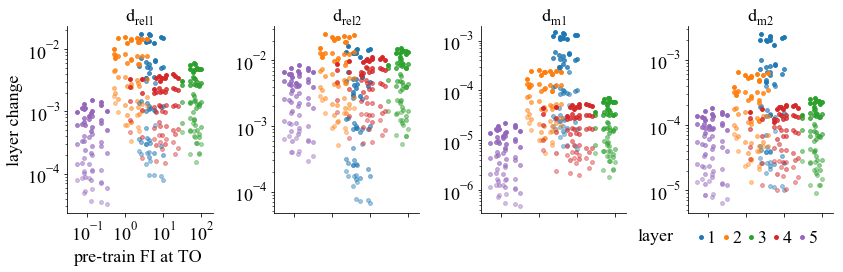

In [11]:
fig, axes = plt.subplots(1,4, figsize=(12,4))

all_feat1={}
all_feat2={}
all_feat3={}

dw_equations = [r'$d_{rel1}$', 
                r'$d_{rel2}$',
               r'$d_{m1}$', 
                r'$d_{m2}$', ]
dw_measures = ["rel_1norm", "rel_2norm", "mean_abs_d", "sqrt_mean_sq_d"]

alpha_dict = {0.5:1.0,
              1.0:0.8,
              2.0:0.6,
              5.0:0.5,
              10.0:0.4}

for mi, wm in enumerate(dw_measures):
    all_feat1[wm] = [[] for i in range(len(blobs))]
    all_feat2[wm] = [[] for i in range(len(blobs))]
    all_feat3[wm] = [[] for i in range(len(blobs))]

    ax = axes[mi]
    ps = []
    for bi, blob in enumerate(blobs):

        for dfi,df in enumerate(dfs):
            feat1 = df.B.t_test[blob]["lfi"]
            all_feat1[wm][bi].append(feat1)
            feat2 = sum_df.iloc[dfi].dws.items()[bi][1][wm][-1]
            all_feat2[wm][bi].append(feat2)
            all_feat3[wm][bi].append(sum_df.iloc[dfi]["d_angle"])
            p = ax.scatter(all_feat1[wm][bi][-1], all_feat2[wm][bi][-1], 15, "C"+str(bi), alpha = alpha_dict[all_feat3[wm][bi][-1]])
        ps.append(p)
    
            
    cool_spines(ax)
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xticks(np.logspace(-1,3,5))
    ax.set_title(dw_equations[mi])
    ax.set_ylim([np.min(all_feat2[wm])*0.7, np.max(all_feat2[wm])*1.3])
    ax.set_xlim([3e-2,2e2])  
    if mi > 0:
        ax.set_xticklabels([])
plt.tight_layout(rect=[0.02,0.013,1.0,0.97])
axes[0].set_xlabel("pre-train FI at TO ")
axes[0].set_ylabel("layer change")

thandle=plt.legend(ps, range(1,6), ncol=5, handlelength=0.1, columnspacing=0.5, handletextpad=0.3, 
                    frameon=False, bbox_to_anchor=(1,0), loc="upper right",fontsize=18)
axes[-1].text(-0.1,-0.08, "layer", transform=axes[-1].transAxes, ha="right", va="top", fontsize=18)

#fig.savefig(fig_dir+'fig_10-1.svg', dpi=300)
#fig.savefig(fig_dir+'fig_10-1.tiff', dpi=300)

In [12]:
factors=["np.log(FI)", "C(layer)","C(d_angle)","C(layer):np.log(FI)","C(d_angle):np.log(FI)" ]
factors=[u'FI',u'C(layer)', u'C(d_angle)',  u'C(layer):FI', u'C(d_angle):FI', ]
stats_table = pd.DataFrame(columns=dw_measures, index=factors)

for wi, wm in enumerate(dw_measures):
    feat1_pd = pd.DataFrame(dict([(i+1, all_feat1[wm][i]) for i in range(5)]))
    feat1_pd = pd.melt(feat1_pd, var_name="layer", value_name = "FI")
    feat2_pd = pd.DataFrame(dict([(i+1, all_feat2[wm][i]) for i in range(5)]))
    feat2_pd = pd.melt(feat2_pd, var_name="layer", value_name = "dw")
    feat3_pd = pd.DataFrame(dict([(i+1, all_feat3[wm][i]) for i in range(5)]))
    feat3_pd = pd.melt(feat3_pd, var_name="layer", value_name = "d_angle")
    dw_FI_pd = pd.concat([feat1_pd, feat3_pd["d_angle"], feat2_pd["dw"]], axis=1)

    model = ols('(dw) ~   (C(layer) + C(d_angle) ) * (FI)', data = dw_FI_pd).fit()
    anova_res = sm.stats.anova_lm(model)
    
    for f in factors:
        stats_str = "F(%d,%d)=%.4g, p=%.2g, R2=%.2g" % (anova_res["df"][f], anova_res["df"]["Residual"],
                                                   anova_res["F"][f], anova_res["PR(>F)"][f], 
                                                   anova_res['sum_sq'][f]/sum(anova_res['sum_sq']))
        stats_table[dw_measures[wi]][f]=stats_str

C:\Anaconda64\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Anaconda64\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Anaconda64\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [13]:
stats_table[dw_measures]

rel_1norm  \
FI             F(1,282)=0.006905, p=0.93, R2=7.7e-06   
C(layer)          F(4,282)=48.27, p=6.7e-31, R2=0.21   
C(d_angle)        F(4,282)=103.3, p=4.7e-54, R2=0.46   
C(layer):FI          F(4,282)=0.02025, p=1, R2=9e-05   
C(d_angle):FI      F(4,282)=2.887, p=0.023, R2=0.013   

                                          rel_2norm  \
FI             F(1,282)=0.03092, p=0.86, R2=1.9e-05   
C(layer)           F(4,282)=50.51, p=5e-32, R2=0.13   
C(d_angle)       F(4,282)=275.6, p=4.3e-96, R2=0.69   
C(layer):FI     F(4,282)=0.1487, p=0.96, R2=0.00037   
C(d_angle):FI     F(4,282)=0.5435, p=0.7, R2=0.0014   

                                           mean_abs_d  \
FI             F(1,282)=0.0003223, p=0.99, R2=5.6e-07   
C(layer)           F(4,282)=40.58, p=7.6e-27, R2=0.28   
C(d_angle)            F(4,282)=28.38, p=8e-20, R2=0.2   
C(layer):FI          F(4,282)=0.001148, p=1, R2=8e-06   
C(d_angle):FI       F(4,282)=3.83, p=0.0048, R2=0.027   

                                     sqrt_mean_sq_d  
FI             F(1,282)=0.00077, p=0.98, R2=1.3e-06  
C(layer)         F(4,282)=33.83, p=4.7e-23, R2=0.22  
C(d_angle)       F(4,282)=42.84, p=4.6e-28, R2=0.28  
C(layer):FI      F(4,282)=0.005635, p=1, R2=3.7e-05  
C(d_angle):FI    F(4,282)=3.704, p=0.0059, R2=0.025

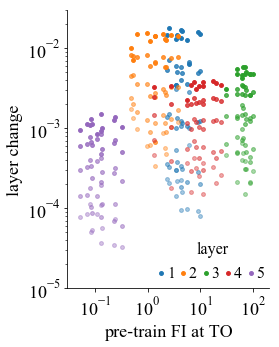

In [14]:
fig, axes = plt.subplots(1, figsize=(4,5))

all_feat1={}
all_feat2={}
all_feat3={}

scatter_points = [None]*5

for mi, wm in enumerate(["rel_1norm"]):
    all_feat1[wm] = [[] for i in range(len(blobs))]
    all_feat2[wm] = [[] for i in range(len(blobs))]
    all_feat3[wm] = [[] for i in range(len(blobs))]

    ax = axes
    for bi, blob in enumerate(blobs):

        for dfi,df in enumerate(dfs):
            feat1 = df.B.t_test[blob]["lfi"]
            all_feat1[wm][bi].append(feat1)
            feat2 = sum_df.iloc[dfi].dws.items()[bi][1][wm][-1]
            all_feat2[wm][bi].append(feat2)
            all_feat3[wm][bi].append(sum_df.iloc[dfi]["d_angle"])
            sp = ax.scatter(all_feat1[wm][bi][-1], all_feat2[wm][bi][-1], 15, "C"+str(bi), alpha = alpha_dict[all_feat3[wm][bi][-1]])
        scatter_points[bi]=sp
cool_spines(axes)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim([1e-5,3e-2])
ax.set_xlim([3e-2,2e2])   
ax.set_xticks(np.logspace(-1,2,4))
thandle=plt.legend(scatter_points, range(1,6),ncol=5, handlelength=0.1, columnspacing=0.5, handletextpad=0.3, 
                    frameon=False, bbox_to_anchor=(1.05,0.22), loc="upper right",fontsize=16)
thandle.set_title("layer", prop={"size":16})
plt.tight_layout(rect=[0.02,0.00,1.0,0.97])

ax.set_xlabel("pre-train FI at TO")
ax.set_ylabel("layer change")

#fig.savefig(fig_dir+'layer_FI_change.svg', dpi=300)

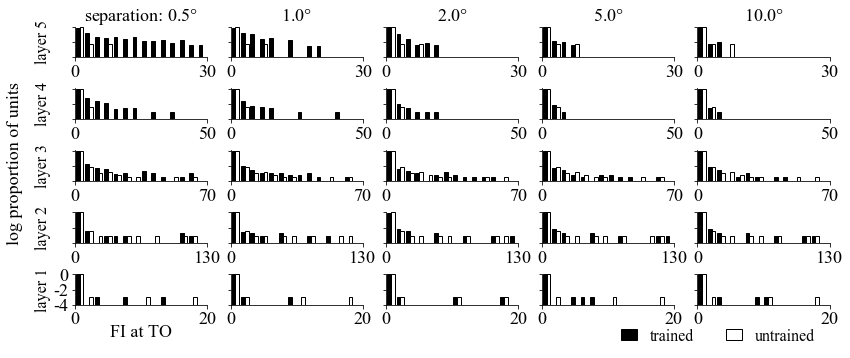

In [16]:
def correlate_two(ax, f1, f2, **kwargs):
    f1 -= np.min(f1)
    f2 -= np.min(f2)
    f1 = f1/(np.abs(f1).max())
    f2 = f2/(np.abs(f2).max())

    ax.scatter(f1, f2, **kwargs)
    cor, p = pearsonr(f1,f2)

    ax.set_xlim([0, 1.55])
    ax.set_ylim([0, 1.1])

    text_x = 0.68
    if p<0.01/25:
        ax.text(text_x ,0.8, r"$%.2f$" % cor, 
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize=16) 
    else:
        ax.text(text_x ,0.8, r"n.s." % cor, 
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize=16)
    return f1, f2

fig, axes = plt.subplots(ndiff, nblob, figsize=(12,5),sharex = False, sharey = False)

feat1 = 'grad2_var'
xlims = np.array([[0,20],[0,130],[0,70],[0,50],[0,30]])
unit_dw_FI_df = pd.DataFrame(columns=["dw","FI","d_angle","layer"])

for di, diff in enumerate(diffs):
    _, idx = lookup(w_df, noise = 15, ctrst = 0.2, wave = 10.0, d_angle = diff)
    if di == 0:
        axes[0,di].set_title(r'separation: %.1f$\degree$' % diff)
    else:
        axes[0,di].set_title('%.1f$\degree$' % diff)


    for bi, blob in enumerate(blobs):

        ax = axes[4-bi, di]
        if di==0:
            ax.text(-0.24,0.5,"layer %d" % (bi+1), rotation=90, 
                       va="center", ha="center", fontsize=16, 
                      transform=ax.transAxes)
        all_feat1_vals = np.array([])
        all_feat2_vals = np.array([])

        for ii, i in enumerate(idx):
            feat1_vals = dfs[i].A.t_test[blob][feat1]
            feat2_vals = dfs[i].B.t_test[blob][feat1]
            #feat1_vals = feat1_vals/ (dfs[i].B.t_test[blob][feat1][B_common]+1e-2)
            #feat1_vals = feat1_vals[np.isfinite(feat1_vals)]

            all_feat1_vals = np.r_[all_feat1_vals, feat1_vals]
            all_feat2_vals = np.r_[all_feat2_vals, feat2_vals]

            
        max_val = max(np.max(np.abs(all_feat1_vals)),np.max(np.abs(all_feat1_vals)))
        nunit1 = len(all_feat1_vals)
        nunit2 = len(all_feat2_vals)
        #all_feat1_vals /= max_val
        _,_,patches = ax.hist([all_feat1_vals,all_feat2_vals], bins=np.linspace(xlims[bi][0], xlims[bi][1],15), 
               weights = [np.ones(nunit1)/nunit1, np.ones(nunit2)/nunit2],
               color=["k","w"], ec="k")

        #ax.hist(all_feat2_vals, bins=np.linspace(xlims[bi][0], xlims[bi][1],30), weights=np.ones(nunit)/nunit)
        
        ax.set_yscale("log", nonposy="clip")

        cool_spines(ax)
        
        if not ((bi==0) and (di == 0)):
            ax.set_yticklabels([])
        ax.set_xticks(xlims[bi])

        ax.set_xlim(*xlims[bi])
        #ax.set_yticks(np.logspace(-4,0,3))
        ax.set_ylim(1.0e-4,1.04e0)
        
fig.tight_layout(rect=[0.02,0.015,1,1.02], w_pad=0.3, h_pad=-0.1)
fig.text(0.01, 0.53, 'log proportion of units', va='center', rotation=90)
axes[4,0].set_xlabel('FI at TO')
axes[4,0].set_yticks([1e-4,0.01,1])

axes[4,0].set_yticklabels([-4,-2,0])
xlabel_pos = axes[4,0].xaxis.get_label().get_position()
xlabel_trans = axes[4,0].xaxis.get_label().get_transform()
axes[4,0].xaxis.set_label_coords(xlabel_pos[0], xlabel_pos[1]+10, transform=xlabel_trans)
axes[4,4].legend([patches[0][0], patches[1][1]], ["trained", "untrained"], ncol=2, loc="upper right", 
                 bbox_to_anchor=[1,-0.3], handlelength=1, frameon=False, fontsize=16)

#fig.savefig(fig_dir+'unit_dFI_dist.svg')

(0.34869196280234493, 3.3986488986861527e-25)
0.533653846154
(0.28901416297773075, 1.9186332313865954e-11)
0.778420038536
(0.11933406200377383, 1.1938798520126302e-06)
0.800242865817
(0.49102524115380036, 2.0309911468626378e-44)
0.869198312236
(0.41839856271737697, 1.621284164394293e-06)
0.983606557377


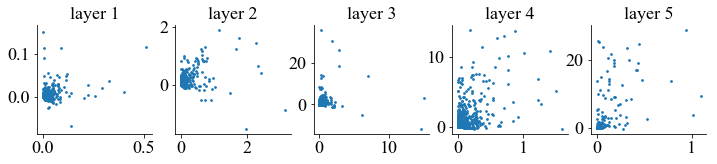

In [17]:
def correlate_two(ax, f1, f2, **kwargs):
    f1 -= np.min(f1)
    f2 -= np.min(f2)
    f1 = f1/(np.abs(f1).max())
    f2 = f2/(np.abs(f2).max())

    ax.scatter(f1, f2, **kwargs)
    cor, p = pearsonr(f1,f2)

    ax.set_xlim([0, 1.55])
    ax.set_ylim([0, 1.1])

    text_x = 0.68
    if p<0.01/25:
        ax.text(text_x ,0.8, r"$%.2f$" % cor, 
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize=16) 
    else:
        ax.text(text_x ,0.8, r"n.s." % cor, 
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize=16)
    return f1, f2

fig, axes = plt.subplots(1, nblob, figsize=(12,2),sharex = False, sharey = False)
axes= axes[None,:]
feat1 = 'abs_grad_std'
xlims = np.array([[0,0.5],[0,5],[0,35],[0,20],[0,30]])
unit_dw_FI_df = pd.DataFrame(columns=["dw","FI","d_angle","layer"])

for di, diff in enumerate([0.5]):
    _, idx = lookup(w_df, noise = 15, ctrst = 0.2, wave = 10.0, d_angle = diff)
    if di == 0:
        axes[0,di].set_title(r'separation: %.1f$\degree$' % diff)
    else:
        axes[0,di].set_title('%.1f$\degree$' % diff)


    for bi, blob in enumerate(blobs):

        ax = axes[di,bi]
        if di==0:
            ax.set_title("layer %d" % (bi+1), fontsize=18)
        all_feat1_vals = np.array([])
        all_feat2_vals = np.array([])

        for ii, i in enumerate(idx):
            
            feat1_vals = dfs[i].A.t_test[blob][feat1]**2
            common1  = dfs[i].A_common[blob]
            feat1_vals = feat1_vals[common1]
            mean1_vals  = dfs[i].A.t_test[blob]["mean"][common1]

            feat2_vals = dfs[i].B.t_test[blob][feat1]**2
            common2  = dfs[i].B_common[blob]
            feat2_vals = feat2_vals[common2]
            mean2_vals  = dfs[i].B.t_test[blob]["mean"][common2]


            nonzeros   = np.logical_and(mean1_vals>0.1, mean2_vals>0.1)
            all_feat1_vals = np.r_[all_feat1_vals, feat1_vals[nonzeros]]
            all_feat2_vals = np.r_[all_feat2_vals, feat2_vals[nonzeros]]

        #all_feat1_vals /= max_val
        ax.scatter(all_feat2_vals, all_feat1_vals - all_feat2_vals,3)
        print pearsonr((all_feat2_vals), (all_feat1_vals - all_feat2_vals))
        print np.mean((all_feat1_vals - all_feat2_vals)>0)
        #ax.set_xscale("log")
        #ax.set_yscale("log")
        #ax.plot([0,10],[0,10])
        #ax.hist(all_feat2_vals, bins=np.linspace(xlims[bi][0], xlims[bi][1],30), weights=np.ones(nunit)/nunit)
        cool_spines(ax)
        #ax.set_ylim(1e-8,1e3)

MannwhitneyuResult(statistic=345061.5, pvalue=0.45733916902955585)
0.000983347010799 0.000903955894233
MannwhitneyuResult(statistic=103704.5, pvalue=7.0841635329662214e-11)
0.0776991541932 0.0275150827765
MannwhitneyuResult(statistic=885707.0, pvalue=6.290977268547016e-67)
0.180529827633 0.0474423964616
MannwhitneyuResult(statistic=108190.0, pvalue=4.1631498073943183e-78)
0.361739313402 0.0409536532338
MannwhitneyuResult(statistic=1572.0, pvalue=8.9526839132690358e-27)
1.67002617296 0.059968660779


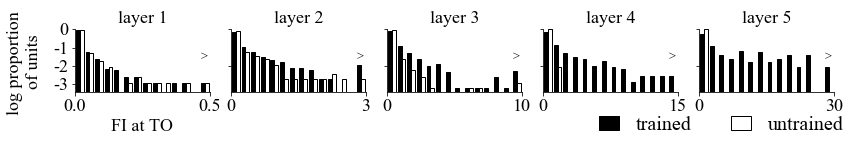

In [18]:
def correlate_two(ax, f1, f2, **kwargs):
    f1 -= np.min(f1)
    f2 -= np.min(f2)
    f1 = f1/(np.abs(f1).max())
    f2 = f2/(np.abs(f2).max())

    ax.scatter(f1, f2, **kwargs)
    cor, p = pearsonr(f1,f2)

    ax.set_xlim([0, 1.55])
    ax.set_ylim([0, 1.1])

    text_x = 0.68
    if p<0.01/25:
        ax.text(text_x ,0.8, r"$%.2f$" % cor, 
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize=16) 
    else:
        ax.text(text_x ,0.8, r"n.s." % cor, 
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize=16)
    return f1, f2

fig, axes = plt.subplots(1, nblob, figsize=(12,2),sharex = False, sharey = False)
axes= axes[None,:]
feat1 = 'abs_grad_std'
xlims = np.array([[0,0.5],[0,3],[0,10],[0,15],[0,30]])
unit_dw_FI_df = pd.DataFrame(columns=["dw","FI","d_angle","layer"])

for di, diff in enumerate([0.5]):
    _, idx = lookup(w_df, noise = 15, ctrst = 0.2, wave = 10.0, d_angle = diff)
    if di == 0:
        axes[0,di].set_title(r'separation: %.1f$\degree$' % diff)
    else:
        axes[0,di].set_title('%.1f$\degree$' % diff)


    for bi, blob in enumerate(blobs):

        ax = axes[0,bi]
        if di==0:
            ax.set_title("layer %d" % (bi+1), fontsize=18)
        all_feat1_vals = np.array([])
        all_feat2_vals = np.array([])

        for ii, i in enumerate(idx):
            
            feat1_vals = dfs[i].A.t_test[blob][feat1]**2
            common1  = dfs[i].A_common[blob]

            feat1_vals = feat1_vals[common1]
            mean1_vals  = dfs[i].A.t_test[blob]["mean"][common1]

            feat2_vals = dfs[i].B.t_test[blob][feat1]**2
            common2  = dfs[i].B_common[blob]
            feat2_vals = feat2_vals[common2]
            mean2_vals  = dfs[i].B.t_test[blob]["mean"][common2]


            nonzeros   = np.logical_and(mean1_vals>0.1, mean2_vals>0.1)
            all_feat1_vals = np.r_[all_feat1_vals, feat1_vals[nonzeros]]
            all_feat2_vals = np.r_[all_feat2_vals, feat2_vals[nonzeros]]
            
        max_val = max(np.max(np.abs(all_feat1_vals)),np.max(np.abs(all_feat1_vals)))
        nunit1 = len(all_feat1_vals)
        nunit2 = len(all_feat2_vals)
        #all_feat1_vals /= max_val
        all_feat1_vals[all_feat1_vals>xlims[bi][1]]=xlims[bi][1]
        all_feat2_vals[all_feat2_vals>xlims[bi][1]]=xlims[bi][1]

        _,_,patches = ax.hist([all_feat1_vals,all_feat2_vals], bins=np.linspace(xlims[bi][0], xlims[bi][1],15), 
               weights = [np.ones(nunit1)/nunit1, np.ones(nunit2)/nunit2],
               color=["k","w"], ec="k")

        #ax.hist(all_feat2_vals, bins=np.linspace(xlims[bi][0], xlims[bi][1],30), weights=np.ones(nunit)/nunit)
        
        ax.set_yscale("log", nonposy="clip")

        cool_spines(ax)
        print mannwhitneyu(all_feat2_vals, all_feat1_vals)
        print np.median(all_feat1_vals), np.median(all_feat2_vals)
        if not ((bi==0) and (di == 0)):
            ax.set_yticklabels([])
        ax.set_xticks(xlims[bi])

        ax.set_xlim(*xlims[bi])
        #ax.set_yticks(np.logspace(-4,0,3))
        ax.set_ylim(4.0e-4,1.04e0)
        ax.text(xlims[bi][1]*0.98,2e-2,">", fontsize=12, ha="right")
        
fig.tight_layout(rect=[0.02,0.015,1,1.02], w_pad=0.3, h_pad=-0.1)
fig.text(0.01, 0.53, 'log proportion \nof units', va='center', rotation=90, multialignment='center')

axes[0,0].set_xlabel('FI at TO')
xlabel_pos = axes[0,0].xaxis.get_label().get_position()
xlabel_trans = axes[0,0].xaxis.get_label().get_transform()
axes[0,0].set_yticks([0.001,0.01,0.1,1])
axes[0,0].xaxis.set_label_coords(xlabel_pos[0], xlabel_pos[1]+45, transform=xlabel_trans)

axes[0,0].set_yticklabels([-3,-2,-1,0])

axes[0,4].legend([patches[0][0], patches[1][1]], ["trained", "untrained"], ncol=2, loc="upper right", 
                 bbox_to_anchor=[1.2,-0.1], handlelength=1, frameon=False, fontsize=20)

#fig.savefig(fig_dir+'unit_dFI_dist.svg')

0.000983347010799 0.000903955894233
0.0776991541932 0.0275150827765
0.180529827633 0.0474423964616
0.361739313402 0.0409536532338
1.67002617296 0.059968660779


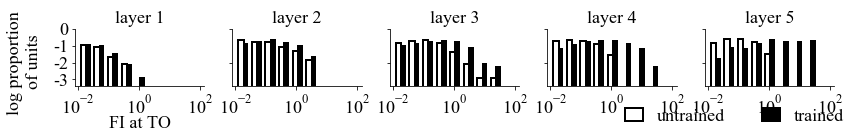

In [19]:
def correlate_two(ax, f1, f2, **kwargs):
    f1 -= np.min(f1)
    f2 -= np.min(f2)
    f1 = f1/(np.abs(f1).max())
    f2 = f2/(np.abs(f2).max())

    ax.scatter(f1, f2, **kwargs)
    cor, p = pearsonr(f1,f2)

    ax.set_xlim([0, 1.55])
    ax.set_ylim([0, 1.1])

    text_x = 0.68
    if p<0.01/25:
        ax.text(text_x ,0.8, r"$%.2f$" % cor, 
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize=16) 
    else:
        ax.text(text_x ,0.8, r"n.s." % cor, 
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize=16)
    return f1, f2

fig, axes = plt.subplots(1, nblob, figsize=(12,2),sharex = False, sharey = False)
axes= axes[None,:]
feat1 = 'abs_grad_std'
xlims = np.log10(np.array([[1e-3,300],[1e-3,300],[1e-3,300],[1e-3,300],[1e-3,300]]))
unit_dw_FI_df = pd.DataFrame(columns=["dw","FI","d_angle","layer"])

for di, diff in enumerate([0.5]):
    _, idx = lookup(w_df, noise = 15, ctrst = 0.2, wave = 10.0, d_angle = diff)
    if di == 0:
        axes[0,di].set_title(r'separation: %.1f$\degree$' % diff)
    else:
        axes[0,di].set_title('%.1f$\degree$' % diff)


    for bi, blob in enumerate(blobs):

        ax = axes[0,bi]
        if di==0:
            ax.set_title("layer %d" % (bi+1), fontsize=18)
        all_feat1_vals = np.array([])
        all_feat2_vals = np.array([])

        for ii, i in enumerate(idx):
            
            feat1_vals = dfs[i].A.t_test[blob][feat1]**2
            common1  = dfs[i].A_common[blob]

            feat1_vals = feat1_vals[common1]
            mean1_vals  = dfs[i].A.t_test[blob]["mean"][common1]

            feat2_vals = dfs[i].B.t_test[blob][feat1]**2
            common2  = dfs[i].B_common[blob]
            feat2_vals = feat2_vals[common2]
            mean2_vals  = dfs[i].B.t_test[blob]["mean"][common2]


            nonzeros   = np.logical_and(mean1_vals>0.1, mean2_vals>0.1)
            all_feat1_vals = np.r_[all_feat1_vals, feat1_vals[nonzeros]]
            all_feat2_vals = np.r_[all_feat2_vals, feat2_vals[nonzeros]]
            
        max_val = max(np.max(np.abs(all_feat1_vals)),np.max(np.abs(all_feat1_vals)))
        nunit1 = len(all_feat1_vals)
        nunit2 = len(all_feat2_vals)
        #all_feat1_vals /= max_val
        _,_,patches = ax.hist([all_feat2_vals, all_feat1_vals], bins=np.logspace(-2,2,10), 
               weights = [np.ones(nunit1)/nunit1, np.ones(nunit2)/nunit2],
               color=["w","k"], ec="k", linewidth=2, rwidth=0.7)

        #ax.hist(all_feat2_vals, bins=np.linspace(xlims[bi][0], xlims[bi][1],30), weights=np.ones(nunit)/nunit)
        
        ax.set_yscale("log", nonposy="clip")
        ax.set_xscale("log")

        cool_spines(ax)
        print np.median(all_feat1_vals), np.median(all_feat2_vals)
        if not ((bi==0) and (di == 0)):
            ax.set_yticklabels([])
        ax.set_xticks(np.logspace(-2,2,3))

        #ax.set_xlim(*xlims[bi])
        #ax.set_yticks(np.logspace(-4,0,3))
        ax.set_ylim(4.0e-4,1.04e0)
        
fig.tight_layout(rect=[0.02,0.015,1,1.02], w_pad=0.3, h_pad=-0.1)
fig.text(0.01, 0.53, 'log proportion \nof units', va='center', rotation=90, multialignment='center')

axes[0,0].set_xlabel('FI at TO')
xlabel_pos = axes[0,0].xaxis.get_label().get_position()
xlabel_trans = axes[0,0].xaxis.get_label().get_transform()
axes[0,0].set_yticks([0.001,0.01,0.1,1])
axes[0,0].xaxis.set_label_coords(xlabel_pos[0], xlabel_pos[1]+45, transform=xlabel_trans)

axes[0,0].set_yticklabels([-3,-2,-1,0])

axes[0,4].legend([patches[0][0], patches[1][1]], ["untrained", "trained"], ncol=2, loc="upper right", 
                 bbox_to_anchor=[1.2,-0.1], handlelength=1, frameon=False, fontsize=18)

#fig.savefig(fig_dir+'unit_dFI_dist.svg')

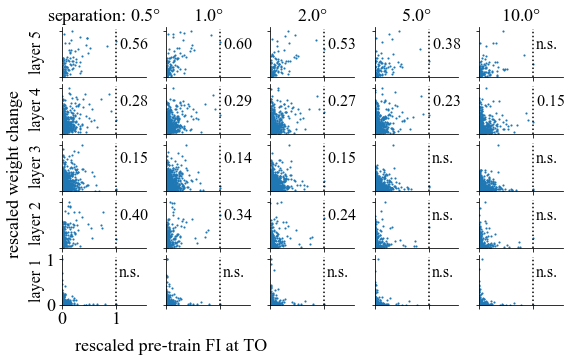

In [20]:
def correlate_two(ax, f1, f2, **kwargs):
    f1 -= np.min(f1)
    f2 -= np.min(f2)
    f1 = f1/(np.abs(f1).max())
    f2 = f2/(np.abs(f2).max())

    ax.scatter(f1, f2, **kwargs)
    cor, p = pearsonr(f1,f2)

    ax.set_xlim([0,1.55])
    ax.set_ylim([0, 1.1])

    text_x = 0.68
    if p<0.01/25:
        ax.text(text_x ,0.8, r"$%.2f$" % cor, 
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize=16) 
    else:
        ax.text(text_x ,0.8, r"n.s." % cor, 
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize=16)
    return f1, f2

fig, axes = plt.subplots(ndiff, nblob, figsize=(8.1,5),sharex = False, sharey = False)

feat1 = 'abs_grad_std'
feat2 = 'rel_1norm'

unit_dw_FI_df = pd.DataFrame(columns=["dw","FI","d_angle","layer"])

for di, diff in enumerate(diffs):
    _, idx = lookup(w_df, noise = 15, ctrst = 0.2, wave = 10.0, d_angle = diff)
    if di == 0:
        axes[0,di].set_title(r'separation: %.1f$\degree$' % diff)
    else:
        axes[0,di].set_title('%.1f$\degree$' % diff)


    for bi, blob in enumerate(blobs):

        ax = axes[4-bi, di]
        if di==0:
            ax.text(-0.3,0.5,"layer %d" % (bi+1), rotation=90, 
                       va="center", ha="center", fontsize=16, 
                      transform=ax.transAxes)
        all_feat1_vals = np.array([])
        all_feat2_vals = np.array([])
        for ii, i in enumerate(idx):
            feat1_vals = dfs[i].B.t_test[blob][feat1][dfs[i].B_common[blob]]**2
            nonzeros   = dfs[i].B.t_test[blob]["mean"][dfs[i].B_common[blob]]>1
            feat2_vals = dfs[i].dt[blob][feat2]
            all_feat1_vals = np.r_[all_feat1_vals, feat1_vals[nonzeros]]
            all_feat2_vals = np.r_[all_feat2_vals, feat2_vals[nonzeros]]
        nunit = len(all_feat1_vals)

        f1, f2 = correlate_two(ax, (all_feat1_vals), (all_feat2_vals), marker = '.', s = 5.0)    
        
        unit_dw_FI_df = pd.concat([unit_dw_FI_df, pd.DataFrame(dict(dw=all_feat2_vals,
                          FI=all_feat1_vals,
                          layer=[(bi+1)]*(nunit),
                          d_angle=[diff]*nunit))], ignore_index=True)
        
        
        cool_spines(ax)
        ax.plot([1,1],[0,1.05],'k:')
        
        if not ((bi==0) and (di == 0)):
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            
fig.tight_layout(rect=[0.04,0.015,1,1.02], w_pad=0, h_pad=0.1)
fig.text(0.01, 0.5, 'rescaled weight change', va='center', rotation=90)
axes[4,0].set_xlabel('rescaled pre-train FI at TO')
xlabel_pos = axes[4,0].xaxis.get_label().get_position()
xlabel_trans = axes[4,0].xaxis.get_label().get_transform()
axes[4,0].xaxis.set_label_coords(xlabel_pos[0]+0.8, xlabel_pos[1]-4, transform=xlabel_trans)

#fig.savefig(fig_dir+'unit_FI_change.svg')

In [21]:
model = ols('dw ~   (C(layer) + C(d_angle))*FI ', data = unit_dw_FI_df).fit()
anova_res = sm.stats.anova_lm(model)
print model.summary()
print anova_res
print anova_res['sum_sq']/sum(anova_res['sum_sq'])

                            OLS Regression Results                            
Dep. Variable:                     dw   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     216.2
Date:                Mon, 12 Mar 2018   Prob (F-statistic):               0.00
Time:                        23:12:43   Log-Likelihood:                 53751.
No. Observations:               19034   AIC:                        -1.075e+05
Df Residuals:                   19016   BIC:                        -1.073e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.01

In [22]:
sg.Figure("18cm", "10.8cm",
       sg.Panel(
          sg.SVG(fig_dir+'layer_FI_change.svg').scale(0.8),
          sg.Text("A", 2, 25, size=15, weight='bold'),
          ).move(0,1),
       sg.Panel(
          sg.SVG(fig_dir+'unit_FI_change.svg').scale(0.8),
          sg.Text("B", 2, 25, size=15, weight='bold').move(5,0),
          ).move(215, 1),
       sg.Panel(
          sg.SVG(fig_dir+'unit_dFI_dist.svg').scale(0.8),
          sg.Text("C", 2, 5, size=15, weight='bold').move(5,0),
          ).move(0, 290),  
).save(fig_dir+"fig_10.svg")
display(SVG(fig_dir+'fig_10.svg'))

In [23]:
factors=["np.log(FI)", "C(layer)","C(d_angle)","C(layer):np.log(FI)","C(d_angle):np.log(FI)" ]
factors=[u'FI',u'C(layer)', u'C(d_angle)',  u'C(layer):FI', u'C(d_angle):FI']

stats_table = pd.DataFrame(columns=dw_measures, index=factors)

for wi, wm in enumerate(dw_measures):
    feat2 = wm
    unit_dw_FI_df = pd.DataFrame(columns=["dw","FI","d_angle","layer"])
            
            
    for di, diff in enumerate(diffs):
        _, idx = lookup(w_df, noise = 15, ctrst = 0.2, wave = 10.0, d_angle = diff)
        if di == 0:
            axes[0,di].set_title('separation: %.1f deg' % diff)
        else:
            axes[0,di].set_title('%.1f deg' % diff)


        for bi, blob in enumerate(blobs):

            ax = axes[4-bi, di]
            if di==0:
                ax.text(-0.3,0.5,"layer %d" % (bi+1), rotation=90, 
                           va="center", ha="center", fontsize=16, 
                          transform=ax.transAxes)
            all_feat1_vals = np.array([])
            all_feat2_vals = np.array([])
            for ii, i in enumerate(idx):
                feat1_vals = dfs[i].B.t_test[blob][feat1][dfs[i].B_common[blob]]**2
                nonzeros   = dfs[i].B.t_test[blob]["mean"][dfs[i].B_common[blob]]>1
                feat2_vals = dfs[i].dt[blob][feat2]
                all_feat1_vals = np.r_[all_feat1_vals, feat1_vals[nonzeros]]
                all_feat2_vals = np.r_[all_feat2_vals, feat2_vals[nonzeros]]
            nunit = len(all_feat1_vals)

            f1, f2 = correlate_two(ax, (all_feat1_vals), (all_feat2_vals), marker = '.', s = 5.0)    

            unit_dw_FI_df = pd.concat([unit_dw_FI_df, pd.DataFrame(dict(dw=all_feat2_vals,
                              FI=all_feat1_vals,
                              layer=[(bi+1)]*(nunit),
                              d_angle=[diff]*nunit))], ignore_index=True)
    
    
    model = ols('(dw) ~   (C(layer) * C(d_angle) ) * (FI)', data = unit_dw_FI_df).fit()
    #print model.summary()
    anova_res = sm.stats.anova_lm(model)
    
    
    for f in factors:
        stats_str = "F(%d,%d)=%.2f, p=%.2g, R2=%.2g" % (anova_res["df"][f], anova_res["df"]["Residual"],
                                                   anova_res["F"][f], anova_res["PR(>F)"][f], 
                                                   anova_res['sum_sq'][f]/sum(anova_res['sum_sq']))
        stats_table[dw_measures[wi]][f]=stats_str

In [24]:
stats_table

rel_1norm  \
FI             F(1,18984)=127.76, p=1.6e-29, R2=0.0053   
C(layer)       F(4,18984)=158.16, p=2.2e-133, R2=0.026   
C(d_angle)             F(4,18984)=750.58, p=0, R2=0.12   
C(layer):FI     F(4,18984)=22.47, p=1.5e-18, R2=0.0037   
C(d_angle):FI     F(4,18984)=32.31, p=7e-27, R2=0.0054   

                                             rel_2norm  \
FI             F(1,18984)=177.70, p=2.3e-40, R2=0.0074   
C(layer)          F(4,18984)=32.60, p=4e-27, R2=0.0054   
C(d_angle)             F(4,18984)=973.87, p=0, R2=0.16   
C(layer):FI      F(4,18984)=24.03, p=7.4e-20, R2=0.004   
C(d_angle):FI   F(4,18984)=38.87, p=1.8e-32, R2=0.0065   

                                            mean_abs_d  \
FI             F(1,18984)=130.61, p=3.8e-30, R2=0.0038   
C(layer)              F(4,18984)=819.25, p=0, R2=0.095   
C(d_angle)            F(4,18984)=1287.37, p=0, R2=0.15   
C(layer):FI    F(4,18984)=191.88, p=1.5e-161, R2=0.022   
C(d_angle):FI   F(4,18984)=35.11, p=2.9e-29, R2=0.0041   

                                       sqrt_mean_sq_d  
FI             F(1,18984)=198.96, p=5.9e-45, R2=0.006  
C(layer)             F(4,18984)=478.17, p=0, R2=0.058  
C(d_angle)            F(4,18984)=1625.12, p=0, R2=0.2  
C(layer):FI    F(4,18984)=168.17, p=9.4e-142, R2=0.02  
C(d_angle):FI  F(4,18984)=48.62, p=9.4e-41, R2=0.0059

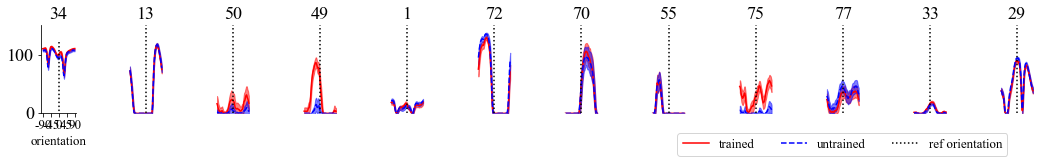

In [25]:
fig, axes = plt.subplots(1,12,figsize=(15,2.5), sharey=True)
axes = axes[None,:]

di = 0
diff = 0.5

_, idx = lookup(w_df, angle = 60.0, wave = 10.0, ctrst = 0.2, d_angle = diff)
idx = idx[0]

blob = 'norm2'


alphas = abs(dfs[idx].dt[blob]['mean']**2)
alphas = dfs[idx].dt_test[blob]['grad']

nn = len(alphas)
A_common = np.where(dfs[idx].A_common[blob])[0]
B_common = np.where(dfs[idx].B_common[blob])[0]
top_idx = np.random.choice(nn,12,replace=False)
for ni, n in enumerate(top_idx):
    ax = axes[di][ni]

    mean_array = dfs[idx].A.t[blob]['mean'][:,A_common[n]]
    std_array  = dfs[idx].A.t[blob]['std'][:,A_common[n]]
    plot_env(ax, angles, mean_array, std_array, std_scale=1, color='r', label = 'trained');

    mean_array = dfs[idx].B.t[blob]['mean'][:,B_common[n]]
    std_array  = dfs[idx].B.t[blob]['std'][:,B_common[n]]
    plot_env(ax, angles, mean_array, y_std=std_array, std_scale=1, color = 'b', ls = '--',  label='untrained');
    ax.plot([-10.0], '^', ms = 10)
    ylim = ax.get_ylim()

    ax.set_title(n)
    ax.plot([0.0,0.0], ylim,':k', label='ref orientation')
    ax.set_ylim([0,150])
    if not(ni == 0):
        ax.set_axis_off()
    else:
        cool_spines(ax)

        ax.set_xlabel('orientation', fontsize=13)
        ax.set_xticks(np.arange(-90,91,45))
        ax.set_xticklabels(np.arange(-90,91,45), fontsize=13)
ax.legend(loc='lower right', bbox_to_anchor=[0.95,0.025],ncol=3,
          bbox_transform=fig.transFigure, prop={'size':13})
fig.tight_layout()

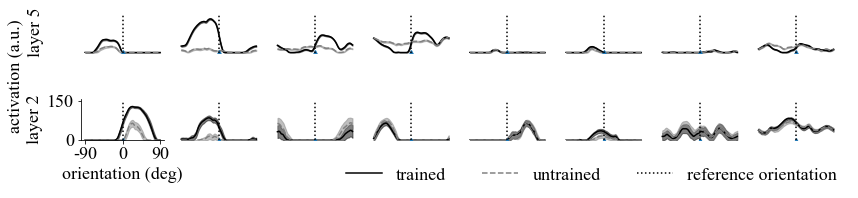

In [26]:
fig, axes = plt.subplots(2,8,figsize=(12,3), )

di = 0
diff = 0.5

top_idx = dict(
            conv5=[1,11,7, 13,9, 4, 3, 5, ],
            conv4=[9,26,51,71,50,56,28,22],
            conv3=[59,53,3,197,1,65,157,92],
            norm2=[44,49,57,58,68,37,78,19]
           )

demo_angles=dict(conv5=30,
                 conv4=60,
                 conv3=120.0,
                 norm2=60.0)

for bi, blob in enumerate(['conv5', 'norm2']):
    _, idx = lookup(w_df, angle = demo_angles[blob], wave = 10.0, ctrst = 0.2, d_angle = diff)
    idx = idx[0]

    A_common = np.where(dfs[idx].A_common[blob])[0]
    B_common = np.where(dfs[idx].B_common[blob])[0]

    for ni, n in enumerate(top_idx[blob]):
        ax = axes[bi][ni]

        mean_array = dfs[idx].A.t[blob]['mean'][:,A_common[n]]
        std_array  = dfs[idx].A.t[blob]['std'][:,A_common[n]]
        plot_env(ax, angles, mean_array, std_array, std_scale=1, color='k', label = 'trained');

        mean_array = dfs[idx].B.t[blob]['mean'][:,B_common[n]]
        std_array  = dfs[idx].B.t[blob]['std'][:,B_common[n]]
        plot_env(ax, angles, mean_array, y_std=std_array, std_scale=1, color = 'gray', ls='--',label='untrained');
        ax.plot([-10.0], '^', ms = 10)
        ylim = ax.get_ylim()

        ax.plot([0.0,0.0], [0,150],':k', label='reference orientation')

        ax.set_ylim([0,160])
        if not(ni == 0 and bi ==1):
            ax.set_axis_off()
        else:
            cool_spines(ax)
            ax.set_xlabel('orientation (deg)')
            ax.set_xticks(np.arange(-90,91,90))
            ax.set_xticklabels(np.arange(-90,91,90))
        ax.set_yticks(np.arange(0,151,150))
        ax.set_yticklabels(np.arange(0,151,150))
            
axes[1,0].set_ylabel('layer 2')
axes[0,0].set_ylabel('layer 5')

axes[0,0].text(-0.55,0.5, 'layer 5',
        ha='center',
        va='center', 
        transform=axes[di,0].transAxes, rotation=90)
fig.text(0.01,0.6, 'activation (a.u.)',
        ha='center',
        va='center', 
        transform=axes[di,0].transAxes, rotation=90)
fig.tight_layout(w_pad=-2.5)
ax.legend(loc='lower right', bbox_to_anchor=[0.98,0.025],ncol=3,
          bbox_transform=fig.transFigure, prop={'size':18}, frameon=False)
#fig.savefig(fig_dir+'tuning_curve.svg')

norm1
4.84610574594
norm2
3.52836925071
conv3
65.6800444445
conv4
10.8935029422
conv5
0.144047797574
norm1
4.84610574594
norm2
3.52836925071
conv3
65.6800444445
conv4
10.8935029422
conv5
0.144047797574
norm1
4.84610574594
norm2
3.52836925071
conv3
65.6800444445
conv4
10.8935029422
conv5
0.144047797574
norm1
4.84610574594
norm2
3.52836925071
conv3
65.6800444445
conv4
10.8935029422
conv5
0.144047797574
norm1
4.84610574594
norm2
3.52836925071
conv3
65.6800444445
conv4
10.8935029422
conv5
0.144047797574


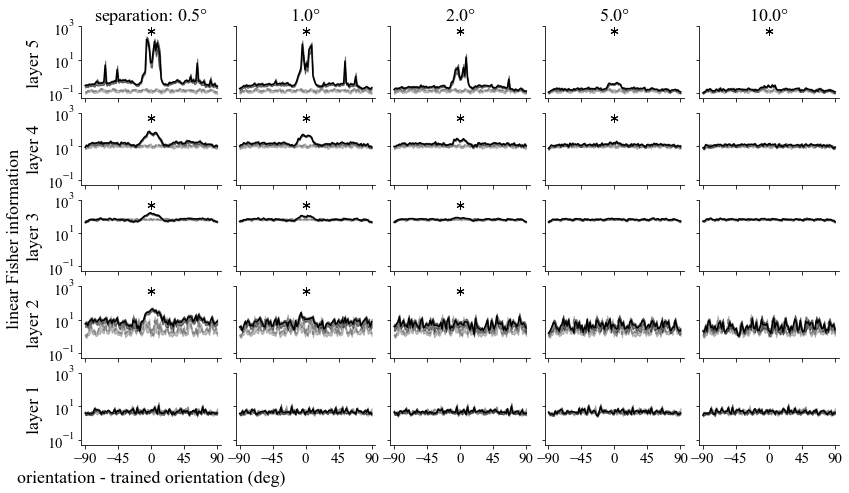

In [27]:
this_blobs = blobs[:]
this_diffs = diffs[:]

fig, axes = plt.subplots(5, 5, figsize=(12,7), sharex = True, sharey = True)

feat1 = 'lfi'

act_df = pd.DataFrame(columns=['change','layer','d_angle'])
for di, diff in enumerate(diffs):
    _, idx = lookup(w_df, wave = 10.0, ctrst = 0.2, d_angle = diff)
    axes[0,di].set_title('%.1f$\degree$' % diff)
    axes[0,0].set_title('separation: %.1f$\degree$' % this_diffs[0])
    for bi, blob in enumerate(blobs):
        
        ax = axes[4-bi, di]
        axes[4-bi, 0].set_ylabel('layer %d' % int(blob[-1]))
        all_feat1_vals = np.zeros([nangle,0])
        all_feat2_vals = np.zeros([nangle,0])
        for ii, i in enumerate(idx):
            feat1_vals = np.abs(dfs[i].A.t[blob][feat1])
            feat2_vals = np.abs(dfs[i].B.t[blob][feat1])
            all_feat1_vals = np.c_[all_feat1_vals, feat1_vals]
            all_feat2_vals = np.c_[all_feat2_vals, feat2_vals]
        print blob
        print all_feat2_vals.mean()
        plot_env(ax, angles, all_feat2_vals, std_scale=np.sqrt(all_feat2_vals.shape[1]), color='gray', ls='--')
        plot_env(ax, angles, all_feat1_vals, std_scale=np.sqrt(all_feat1_vals.shape[1]), color='k')

        cool_spines(ax)
        bar = np.zeros(nangle)

        act_df = act_df.append(pd.DataFrame(dict(change=all_feat1_vals[44:55].mean(0), train=1,
                                  layer=(bi+1), d_angle=diff)))
        
        _, pv = mannwhitneyu(all_feat1_vals[44:55].reshape(-1), all_feat2_vals[44:55].reshape(-1))
        if pv < 0.01/25:
            ax.plot(0, 500, 'k', marker=(6,2,0), markersize=8)
            #ax.plot([45,54],[200,200], 'k',lw=2)
        ax.xaxis.set_ticks_position('bottom')
        
        ax.yaxis.set_ticks_position('left')
        ax.set_xticks([-90,-45,0,45,90])
        
        ax.set_yscale('log')
        ax.tick_params(labelsize=15)


        ax.set_yticks([1e-1,1e1,1e3])
        ax.set_ylim([5e-2,1e3])
        #x.set_yticklabels([1e-1,1e1,1e3],fontsize=15)

        ax.set_xlim([-95.0,95.0])
        ax.set_ylim()
        ax.minorticks_off()

fig.text(0.01, 0.5, 'linear Fisher information', va='center', ha='left', rotation=90)
fig.tight_layout(rect=[0.01,0.01,1,1], h_pad=0.01, w_pad=0.1)
axes[-1,0].set_xlabel('orientation - trained orientation (deg)')

#fig.savefig(fig_dir+'fig_4.svg', dpi=300)

In [28]:
model = ols('change ~ C(layer) * C(d_angle)', data = act_df).fit()
anova_res = sm.stats.anova_lm(model)
print anova_res
print anova_res['sum_sq']/sum(anova_res['sum_sq'])*100

                        df         sum_sq       mean_sq           F  \
C(layer)               4.0  282262.414530  70565.603633  365.461049   
C(d_angle)             4.0   62784.105428  15696.026357   81.290118   
C(layer):C(d_angle)   16.0   24439.480230   1527.467514    7.910793   
Residual             275.0   53098.794072    193.086524         NaN   

                            PR(>F)  
C(layer)             1.019310e-108  
C(d_angle)            1.881063e-45  
C(layer):C(d_angle)   1.917949e-15  
Residual                       NaN  
C(layer)               66.794267
C(d_angle)             14.857162
C(layer):C(d_angle)     5.783332
Residual               12.565240
Name: sum_sq, dtype: float64


13
13


<Container object of 3 artists>

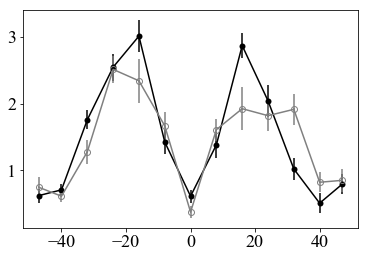

In [29]:
schoups_slope_x = [-47,-40,-32,-24,-16,-8,0,8,16,24,32,40,47]

schoups_slope1_mean = np.array([131,149,370,536,634,300,129,291,604,430,215,107,167])*3/631.0
schoups_slope2_mean = (786-np.array([629,657,517,257,293,435,707,447,381,403,383,613,607]))*3/631.0

schoups_slope1_sem  = np.array([44, 39, 61, 86, 100, 77, 42, 82, 80, 102,68, 62, 65])*3/631.0/2
schoups_slope2_sem  = np.array([63, 39, 77, 85, 139, 88, 37, 70, 136, 97, 96, 64, 73])*3/631.0/2
print len(schoups_slope1_sem)
print len(schoups_slope2_sem)

fig, ax = plt.subplots()
ax.errorbar(schoups_slope_x, schoups_slope1_mean, schoups_slope1_sem, schoups_slope1_sem,
            lw=1.5, color='k',marker='o',markeredgecolor='none')

ax.errorbar(schoups_slope_x, schoups_slope2_mean, schoups_slope2_sem, schoups_slope2_sem,
            color='gray', marker='o', fillstyle = 'none')

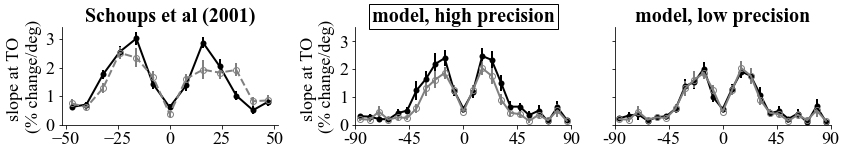

In [30]:
feat1 = 'ori'
feat2 = 'abs_grad'

nbins = 24
bins = np.linspace(-90.0,90.0,nbins)
bin_centers = (bins[1:]+bins[:-1])/2.0
this_blobs = blobs[1:0:-1]
this_diffs = [diffs[i] for i in [1,3]]
nblob = len(this_blobs)
ndiff = len(this_diffs)

fig, axes = plt.subplots(nblob, ndiff+1, figsize=(12,2.5) ) 
axes = axes[None, :]
for di, diff in enumerate(this_diffs):
    _, idx = lookup(w_df, noise = 15.0, wave = 10.0, ctrst = 0.2, d_angle = diff)

    for bi, blob in enumerate(this_blobs):
        
        ax = axes[bi, di+1]

        all_feat1_vals = np.array([])
        all_feat2_vals = np.array([])

        for ii, i in enumerate(idx):
            feat1_vals = dfs[i].A.t[blob][feat1] - w_df['angle'].iloc[i]
            feat2_vals = dfs[i].A.t_test[blob][feat2]/dfs[i].A.t_test[blob]['mean'].max()*100
            all_feat1_vals = np.r_[all_feat1_vals, feat1_vals]
            all_feat2_vals = np.r_[all_feat2_vals, feat2_vals]

        #ax.scatter(all_feat1_vals, all_feat2_vals, s=1, color = 'r', alpha = 0.3)    
        #ax.set_ylim([0,0.0013])
        _, _, trained_vals = scatter_errorbar(ax, (all_feat1_vals), all_feat2_vals, bins, 
                                              lw=2, color='k',marker='o',markeredgecolor='none');


        all_feat1_vals = np.array([])
        all_feat2_vals = np.array([])
        for ii, i in enumerate(idx):
            feat1_vals = dfs[i].B.t[blob][feat1] - w_df['angle'].iloc[i]
            feat2_vals = dfs[i].B.t_test[blob][feat2]/dfs[i].B.t_test[blob]['mean'].max()*100
            all_feat1_vals = np.r_[all_feat1_vals, feat1_vals]
            all_feat2_vals = np.r_[all_feat2_vals, feat2_vals]

        #ax.scatter(all_feat1_vals, all_feat2_vals, s=1,color='k', alpha = 0.1)    
        _, _, untrained_vals = scatter_errorbar(ax, (all_feat1_vals), all_feat2_vals, bins, 
                                                lw=2, color='gray', marker='o', fillstyle = 'none');
        '''
        for bini in range(nbins-1):
            F_value, p_value = ttest_ind(trained_vals[bini], untrained_vals[bini])
            if p_value < 0.05/13/4:
                ax.plot([bin_centers[bini]], [2.8], '*', color = 'k')
        '''
        ax.set_ylim([0,3.5])
        ax.set_yticks([0,1,2,3])
        ax.set_xlim([-90.0,90.0])
        ax_xticks(ax, np.arange(-90,91,45), np.arange(-90,91,45))
        ##ax_yticks(ax, np.arange(1,4.0), np.arange(1,4.0))
        cool_spines(ax)

axes[0,1].set_title('model, high precision', fontsize=20, weight = 'bold',bbox={'fc':'w', 'pad':3})
axes[0,2].set_title('model, low precision', fontsize=20, weight = 'bold')

#axes[-1,0].set_xlabel('Preferred orientation - trained orientation (deg)')
axes[0,0].set_ylabel('slope at TO \n(% change/deg)')
axes[0,1].set_ylabel('slope at TO \n(% change/deg)')
axes[0,2].set_yticklabels([])


data_img = misc.imread(fig_dir+'schoups1.tiff')
ax = axes[0,0]
ax.errorbar(schoups_slope_x, schoups_slope1_mean, schoups_slope1_sem, schoups_slope1_sem,
            lw=2, color='k',marker='o',markeredgecolor='none')

ax.errorbar(schoups_slope_x, schoups_slope2_mean, schoups_slope2_sem, schoups_slope2_sem,
            lw=2, color='gray', ls='--', marker='o', fillstyle = 'none')
cool_spines(ax)
ax.set_title('Schoups et al (2001)', fontsize=20,  weight='bold')
ax.set_xticks([-50,-25,0,25,50]);
ax.set_yticks([0,1,2,3]);


fig.tight_layout()
ax_width = 0.25
ax_poses= [0.08,ax_width,0.42,ax_width, 0.72,ax_width]
for i in range(3):
    ax_pos = list(axes[0,i].get_position().bounds)
    ax_pos[0] = ax_poses[i*2]
    ax_pos[2] = ax_poses[i*2+1]
    axes[0,i].set_position(ax_pos)

#fig.savefig(fig_dir + 'slope_TO_two_side.svg', dpi=1000)


norm2 1.0
ks:  0.023113250386 0.930063241349 1089 1092
x:   28.0798898072 0.0031473566175
x2: (8, n=2181)=11.4, p=0.41
norm2 5.0
ks:  0.0113445378151 0.999999703376 1105 1092
x:   9.58823529412 0.567760909583
x2: (8, n=2197)=2.6, p=1


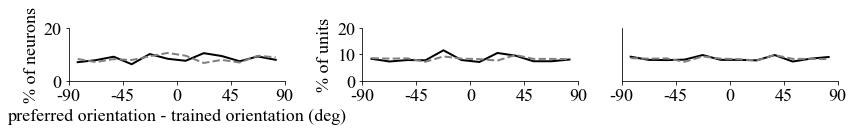

In [31]:
feat1 = 'ori'
nbins = 13
bins = np.linspace(-90.0,90.0,nbins)
bin_centers = (bins[1:]+bins[:-1])/2.0
this_blobs = blobs[1:2]
this_diffs = [diffs[i] for i in [1,3]]
nblob = len(this_blobs)
ndiff = len(this_diffs)

fig, axes = plt.subplots(nblob, ndiff+1, figsize=(12,2), sharex = True)
axes = axes[None, :]
for di, diff in enumerate(this_diffs):
    _, idx = lookup(w_df, noise = 15.0, wave = 10.0, ctrst = 0.2, d_angle = diff)
    #axes[0,di].set_title('%.1f deg' % diff)
    
    for bi, blob in enumerate(this_blobs):
        print blob, diff
        
        ax = axes[nblob-1-bi, di+1]        
        all_feat1_vals = np.array([])
        for ii, i in enumerate(idx):
            feat1_vals = dfs[i].A.t[blob][feat1] - w_df['angle'].iloc[i]
            all_feat1_vals = np.r_[all_feat1_vals, feat1_vals]

        counts = np.histogram(all_feat1_vals, bins)[0].astype('float')
        ax.plot(bin_centers, counts/counts.sum()*100, 
               color = 'k', linewidth = 2)
        trained_counts = counts.copy()

        all_feat2_vals = np.array([])
        for ii, i in enumerate(idx):
            feat2_vals = dfs[i].B.t[blob][feat1] - w_df['angle'].iloc[i]
            all_feat2_vals = np.r_[all_feat2_vals, feat2_vals]
        counts = np.histogram(all_feat2_vals, bins)[0].astype('float')
        untrained_counts = counts.copy()
        
        ax.plot(bin_centers, counts/counts.sum()*100, 
               color = 'gray', ls='--',lw = 2)

        d_value, pv = ks_2samp(all_feat1_vals, all_feat2_vals)
        print 'ks: ', d_value, pv, len(all_feat1_vals), len(all_feat2_vals)
        if pv < 0.01:
            ax.text(40, 16, 'p=%.2g' % pv)
        x2, pv = chisquare(trained_counts)[:2]
        print 'x:  ', x2, pv
        x2, pv = chi2_contingency(np.c_[trained_counts, untrained_counts])[:2]
    
        print 'x2: (8, n=%d)=%.1f, p=%.2g' % ( sum(trained_counts)+sum(untrained_counts),
                                             x2, pv)
        
        ax.set_ylim([0,20])
        ax.set_xlim([-95,95])
        ax_xticks(ax, [-90,-45,0,45,90], [-90,-45,0,45,90])
        ax.set_yticks(np.arange(0,21,10))
        ax.set_yticklabels(np.arange(0,21,10))
        #ax.plot(0,15,'v', color = 'g', ms = 10)
        cool_spines(ax)

#axes[0,1].set_title('Model, low precision')
#axes[0,0].set_title('Model, high precision')
#axes[-1,0].set_xlabel('Preferred orientation - trained orientation (deg)')
axes[0,0].set_ylabel('% of Units')

schoups_dis1 = [244.0020492,394.6200704,324.4934514,294.9050695,407.6530387,
                365.3874656,288.0017361,359.0710236,309.2199864,274.3902331,
                303.8321905,355.0774563,
]
# trained
schoups_dis2 = [306.001634,360.6688232,410.4400078,369.1530848,262.2308144,
                307.1481727,269.0074348,368.4019544,345.5792239,320.3825838,
                275.6592099,318.9388656]

schoups_dis1 = np.roll(schoups_dis1, 3)/np.sum(schoups_dis1)*100
schoups_dis2 = np.roll(schoups_dis2, 3)/np.sum(schoups_dis2)*100
ax = axes[0,0]
ax.plot(bin_centers, schoups_dis1, 'k', lw=2)
ax.plot(bin_centers, schoups_dis2, 'gray', ls='--', lw=2)
ax.set_ylim([0,20])
ax.set_xlim([-90,90])
ax.set_ylabel('% of neurons')
axes[0,1].set_ylabel('% of units')
axes[0,-1].set_yticks([])


ax.set_xlabel('preferred orientation - trained orientation (deg)')

ax_xticks(ax, [-90,-45,0,45,90], [-90,-45,0,45,90])
#ax.plot(0,15,'v', color = 'g', ms = 10)
cool_spines(ax)


fig.tight_layout()
for i in range(3):
    ax_pos = list(axes[0,i].get_position().bounds)
    ax_pos[0] = ax_poses[i*2]
    ax_pos[2] = ax_poses[i*2+1]
    axes[0,i].set_position(ax_pos)
    
#fig.savefig(fig_dir + 'prefer_ori_dist.svg', dpi=1000)

In [32]:
sg.Figure("18cm", "12cm",
       sg.Panel(
          sg.SVG(fig_dir+'tuning_curve.svg').move(0,10).scale(0.8),
          sg.Text("A", 10, 5, size=15, weight='bold').move(0,10),
          ),
       sg.Panel(
          sg.SVG(fig_dir+'slope_TO_two_side.svg').scale(0.8),
          sg.Text("B", 10, 5, size=15, weight='bold'),
          sg.Text("C", 260, 5, size=15, weight='bold'),
          ).move(0, 190),
       sg.Panel(
          sg.SVG(fig_dir+'prefer_ori_dist.svg').move(0,10).scale(0.8),
          sg.Text("D", 10, 5, size=15, weight='bold'),
          sg.Text("E", 260, 5, size=15, weight='bold'),
          ).move(0,340),
).save(fig_dir+"fig_6.svg")
display(SVG(fig_dir+'fig_6.svg'))
          

### Amplitude grouping by preferred orientation
Fig 5 in 

Ghose, G. M., Yang, T., Maunsell, J. H. R., Geoffrey, M., Yang, T., & Maunsell, J. H. R. (2002). Physiological Correlates of Perceptual Learning in Monkey V1 and V2. J Neurophysiol, 87(4), 1867–1888. http://doi.org/10.1152/jn.00690.2001

In [43]:
len(ghose_ta_V1_mean)

9

<Container object of 9 artists>

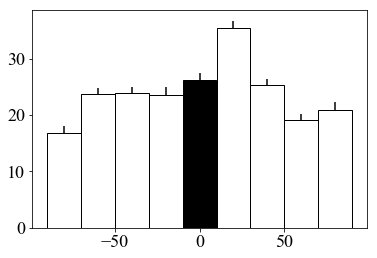

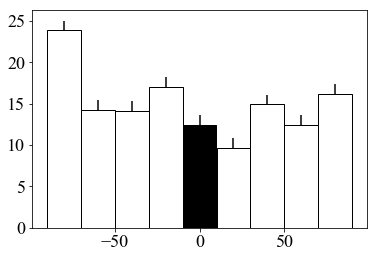

In [47]:
scale = 2.0/559
ghose_ta_V2_mean =np.array([255, 257, 244, 207, 248, 282, 271, 298, 256])
ghose_ta_V2_sem = ghose_ta_V2_mean - np.array([236, 213, 211, 176, 235, 268, 238, 269, 235])
ghose_ta_V2_mean = 640-ghose_ta_V2_mean

ghose_ta_V1_mean =np.array([996, 973, 1011, 1042, 989, 1011, 979, 932, 995])
ghose_ta_V1_sem = ghose_ta_V1_mean - np.array([968, 948, 994,  1018, 972, 990, 957, 914,  969])
ghose_ta_V1_mean = 1317-ghose_ta_V1_mean


ghose_ta_V2_mean = 10**(np.roll(ghose_ta_V2_mean,2) * scale)
ghose_ta_V2_sem = 10**(np.roll(ghose_ta_V2_sem,2) * scale)
ghose_ta_V1_mean = 10**(np.roll(ghose_ta_V1_mean,2) * scale)
ghose_ta_V1_sem = 10**(np.roll(ghose_ta_V1_sem,2) * scale)

nbins = 10
bins = np.linspace(-90.1,90.1,nbins)
bin_centers = (bins[1:]+bins[:-1])/2.0
bar_colors = ['w' for _ in range(nbins-1)]
bar_colors[nbins/2-1] = 'k'

fig, ax = plt.subplots()
ax.bar(bin_centers, ghose_ta_V2_mean, yerr = ghose_ta_V2_sem, align = 'center', 
       color = bar_colors,  width= 180.0/(nbins-1), ec = 'k', zorder=3)


fig, ax = plt.subplots()
ax.bar(bin_centers, ghose_ta_V1_mean, yerr = ghose_ta_V1_sem, align = 'center', 
       color = bar_colors,  width= 180.0/(nbins-1), ec = 'k', zorder=3)

x1: 0.72449, 0.67002
x1: 3.9978, 9.9634e-05
x1: 0.44332, 0.89523
x1: 1.1931, 0.29891


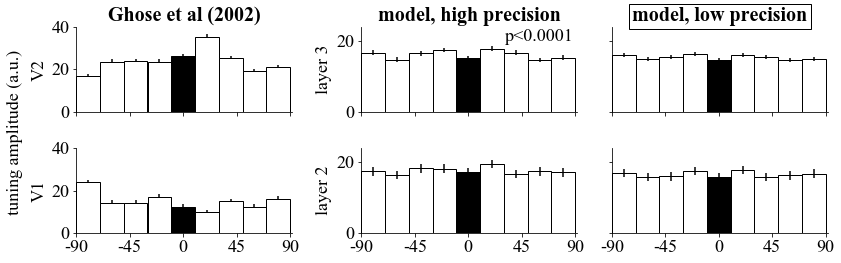

In [48]:
feat1 = 'ori'
feat2 = 'mean'

nbins = 10
bins = np.linspace(-90.1,90.1,nbins)
bin_centers = (bins[1:]+bins[:-1])/2.0
this_blobs = [blobs[i] for i in [1,2]]
this_diffs = [diffs[i] for i in [1,3]]
nblob = len(this_blobs)
ndiff = len(this_diffs)
bar_colors = ['w' for _ in range(nbins-1)]
bar_colors[nbins/2-1] = 'k'

fig, axes = plt.subplots(nblob, ndiff+1, figsize=(12,4), sharex = True)
for di, diff in enumerate(this_diffs):
    _, idx = lookup(w_df, noise = 15.0, wave = 10.0, ctrst = 0.2, d_angle = diff)
    #axes[0,di].set_title('%.1f deg' % diff)
    
    for bi, blob in enumerate(this_blobs):
        
        ax = axes[nblob-1-bi, di+1]

        all_feat1_vals = np.array([])
        all_feat2_vals = np.array([])

        for ii, i in enumerate(idx):
            feat1_vals = dfs[i].A.t[blob][feat1] - w_df['angle'].iloc[i]
            feat2_vals = dfs[i].A.t[blob][feat2].ptp(0)
            all_feat1_vals = np.r_[all_feat1_vals, feat1_vals]
            all_feat2_vals = np.r_[all_feat2_vals, feat2_vals]

        #ax.scatter(all_feat1_vals, all_feat2_vals, s=1, color = 'r', alpha = 0.3)    
        #ax.set_ylim([0,0.0013])
        _, _, trained_vals = scatter_errorbar(ax, (all_feat1_vals), all_feat2_vals, bins, plot=False,
                                              lw=2.0, color='k', ls = '-');
        ax.bar(bin_centers, map(np.mean, trained_vals), yerr = map(sem, trained_vals), align = 'center', 
               color = bar_colors,  width= 180.0/(nbins-1), ec = 'k')
        
        all_feat1_vals = np.array([])
        all_feat2_vals = np.array([])
        for ii, i in enumerate(idx):
            feat1_vals = dfs[i].B.t[blob][feat1] - w_df['angle'].iloc[i]
            feat2_vals = dfs[i].B.t[blob][feat2].ptp(0)
            all_feat1_vals = np.r_[all_feat1_vals, feat1_vals]
            all_feat2_vals = np.r_[all_feat2_vals, feat2_vals]
        
        #ax.scatter(all_feat1_vals, all_feat2_vals, s=1,color='k', alpha = 0.1)    
        _, _, untrained_vals = scatter_errorbar(ax, (all_feat1_vals), all_feat2_vals, bins, 
                                                lw=2.0, color='gray', ls='--', plot = False);
        '''
        for bini in range(nbins-1):
            F_value, p_value = ttest_ind(trained_vals[bini], untrained_vals[bini])
            if p_value < 0.05:
                ax.plot([bin_centers[bini]], [60], '*', color = 'k')
        '''
        fv, pv = f_oneway(*trained_vals)
        print 'x1: %.5g, %.5g' %( fv, pv)
        if pv < 0.0001:
            ax.text(30, 50, 'p<0.0001' % pv)
            

        ax.set_xlim([-90.0,92.0])
        cool_spines(ax)
        ax.set_ylim(0,60)
        ax.set_yticklabels(np.arange(0,61,20))
        
        ax_xticks(ax, [-90,-45,0,45,90], [-90,-45,0,45,90])
        

axes[0,2].set_title('model, low precision', weight='bold', bbox={'fc':'w', 'pad':3}, fontsize=20)
axes[0,1].set_title('model, high precision', weight='bold', fontsize=20)
axes[0,-1].set_yticklabels([])
axes[1,-1].set_yticklabels([])

#axes[-1,0].set_xlabel('Preferred orientation - trained orientation (deg)')
fig.tight_layout(rect=[0.37,0.05,1,1])

axes[1,0].set_ylabel('V1')
axes[0,0].set_ylabel('V2')
fig.text(0.01,0.5, 'tuning amplitude (a.u.)', va='center', rotation=90)

axes[1,1].set_ylabel('layer 2')
axes[0,1].set_ylabel('layer 3')

ax = axes[0,0]
ax.bar(bin_centers, ghose_ta_V2_mean, yerr = ghose_ta_V2_sem, align = 'center', 
       color = bar_colors,  width= 180.0/(nbins-1), ec = 'k', zorder=3)
cool_spines(ax)
ax.set_title('Ghose et al (2002)', fontsize=20, weight='bold')
ax.set_yticks([0,20,40])

ax = axes[1,0]
ax.bar(bin_centers, ghose_ta_V1_mean, yerr = ghose_ta_V1_sem, align = 'center', 
       color = bar_colors,  width= 180.0/(nbins-1), ec = 'k', zorder=3)
cool_spines(ax)
ax.set_yticks([0,20,40])


fig.tight_layout()
ax_width = 0.25
ax_poses= [0.09,ax_width,0.42,ax_width, 0.71, ax_width]
for i in range(3):
    for j in range(2):
        ax_pos = list(axes[j,i].get_position().bounds)
        ax_pos[0] = ax_poses[i*2]
        ax_pos[2] = ax_poses[i*2+1]
        axes[j,i].set_position(ax_pos)

fig.savefig(fig_dir + 'tuning_amplitude.svg', dpi=1000)

<Container object of 9 artists>

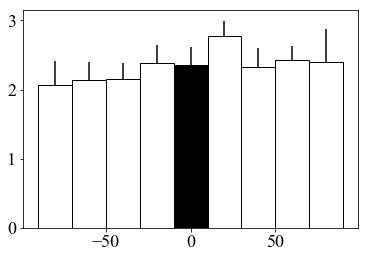

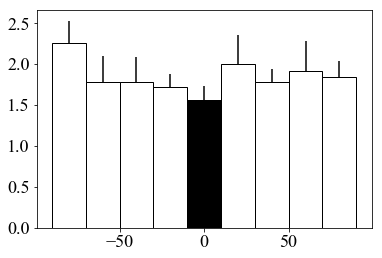

In [49]:
scale = 4.0/558
ghose_vr_V2_mean =np.array([322, 290, 293, 235, 298, 284, 288, 334, 324])
ghose_vr_V2_sem = ghose_vr_V2_mean - np.array([289, 254, 257, 204, 260, 256, 220, 286, 288])
ghose_vr_V2_mean = 622-ghose_vr_V2_mean

ghose_vr_V1_mean =np.array([1059, 1067, 1089, 1028, 1059, 1039, 1050, 992, 1059])
ghose_vr_V1_sem = ghose_vr_V1_mean - np.array([1016, 1045, 1065, 979, 1036, 988, 1023, 954, 1015])
ghose_vr_V1_mean = 1307-ghose_vr_V1_mean


ghose_vr_V2_mean = np.roll(ghose_vr_V2_mean,2) * scale
ghose_vr_V2_sem = np.roll(ghose_vr_V2_sem,2) * scale
ghose_vr_V1_mean = np.roll(ghose_vr_V1_mean,2) * scale
ghose_vr_V1_sem = np.roll(ghose_vr_V1_sem,2) * scale

fig, ax = plt.subplots()
ax.bar(bin_centers, ghose_vr_V2_mean, yerr = ghose_vr_V2_sem, align = 'center', 
       color = bar_colors,  width= 180.0/(nbins-1), ec = 'k', zorder=3)


fig, ax = plt.subplots()
ax.bar(bin_centers, ghose_vr_V1_mean, yerr = ghose_vr_V1_sem, align = 'center', 
       color = bar_colors,  width= 180.0/(nbins-1), ec = 'k', zorder=3)

x1: 0.99765, 0.43603
x1: 0.66629, 0.72169
x1: 0.70758, 0.68508
x1: 0.60558, 0.77394


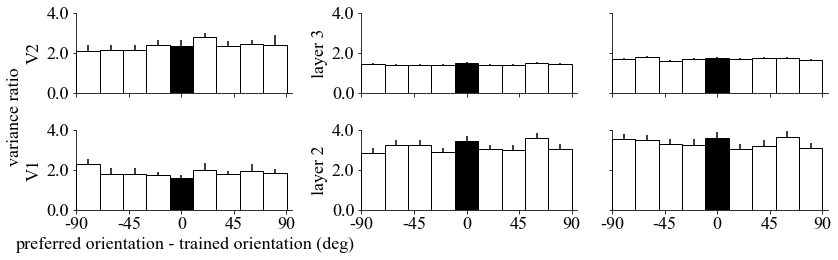

In [50]:
feat1 = 'ori'
feat2 = 'mean_var'

nbins = 10
bins = np.linspace(-90.1,90.1,nbins)
bin_centers = (bins[1:]+bins[:-1])/2.0
this_blobs = [blobs[i] for i in [1,2]]
this_diffs = [diffs[i] for i in [1,3]]
nblob = len(this_blobs)
ndiff = len(this_diffs)

fig, axes = plt.subplots(nblob, ndiff+1, figsize=(12,4), sharex = True)
for di, diff in enumerate(this_diffs):
    _, idx = lookup(w_df, noise = 15.0, wave = 10.0, ctrst = 0.2, d_angle = diff)
    #axes[0,di].set_title('%.1f deg' % diff)
    
    for bi, blob in enumerate(this_blobs):
        
        ax = axes[nblob-1-bi, di+1]
        all_feat1_vals = np.array([])
        all_feat2_vals = np.array([])

        for ii, i in enumerate(idx):
            feat1_vals = dfs[i].A.t[blob][feat1] - w_df['angle'].iloc[i]
            feat2_vals = (dfs[i].A.t[blob]['var'] / ( 0.1 + dfs[i].A.t[blob]['mean'])).mean(0)
            all_feat1_vals = np.r_[all_feat1_vals, feat1_vals]
            all_feat2_vals = np.r_[all_feat2_vals, feat2_vals]
            

        _, _, trained_vals = scatter_errorbar(ax, (all_feat1_vals), all_feat2_vals, bins, plot=False,
                                              lw=2.0, color='k', ls = '-');
        ax.bar(bin_centers, map(np.mean, trained_vals), yerr = map(sem, trained_vals), align = 'center', 
               color = bar_colors,  width= 180.0/(nbins-1), ec = 'k', zorder=3)
        
        '''  
        all_feat1_vals = np.array([])
        all_feat2_vals = np.array([])
        for ii, i in enumerate(idx):
            feat1_vals = dfs[i].B.t[blob][feat1] - w_df['angle'].iloc[i]
            feat2_vals = 1/dfs[i].B.t[blob][feat2].mean(0)
            all_feat1_vals = np.r_[all_feat1_vals, feat1_vals]
            all_feat2_vals = np.r_[all_feat2_vals, feat2_vals]

        _, _, untrained_vals = scatter_errorbar(ax, (all_feat1_vals), all_feat2_vals, bins, 
                                                lw=2.0, color='gray', ls='--');
        for bini in range(nbins-1):
            F_value, p_value = ttest_ind(trained_vals[bini], untrained_vals[bini])
            if p_value < 0.05:
                ax.plot([bin_centers[bini]], [60], '*', color = 'k')
        print ttest_ind(np.concatenate(trained_vals).flatten(), np.concatenate(untrained_vals).flatten())

        '''
        fv, pv = f_oneway(*trained_vals)
        print 'x1: %.5g, %.5g' %( fv, pv)
        if pv < 0.01:
            ax.text(40, 10, 'p=%.2g' % pv)
        ax.set_xlim([-90.0,95])
        ax.set_ylim([0,4])
        ax.set_yticks([0,2,4])
        ax.set_yticklabels([0.0,2.0,4.0])
           

        ax_xticks(ax, [-90,-45,0,45,90], [-90,-45,0,45,90])
        cool_spines(ax)
        
#axes[0,1].set_title('Model, low precision')
#axes[0,0].set_title('Model, high precision')
axes[1,0].set_ylabel('layer 2')
axes[0,0].set_ylabel('layer 3')
axes[-1,0].set_xlabel('preferred orientation - trained orientation (deg)')
axes[0,-1].set_yticklabels([])
axes[1,-1].set_yticklabels([])

axes[1,0].set_ylabel('V1')
axes[0,0].set_ylabel('V2')
fig.text(0.01,0.55, 'variance ratio', va='center', rotation=90)

axes[1,1].set_ylabel('layer 2')
axes[0,1].set_ylabel('layer 3')

ax = axes[0,0]
ax.bar(bin_centers, ghose_vr_V2_mean, yerr = ghose_vr_V2_sem, align = 'center', 
       color = bar_colors,  width= 180.0/(nbins-1), ec = 'k', zorder=3)
cool_spines(ax)
ax.set_ylim([0,4])
ax.set_yticks([0.0,2.0,4.0])
ax.set_yticklabels([0.0,2.0,4.0])



ax = axes[1,0]
ax.bar(bin_centers, ghose_vr_V1_mean, yerr = ghose_vr_V1_sem, align = 'center', 
       color = bar_colors,  width= 180.0/(nbins-1), ec = 'k', zorder=3)
cool_spines(ax)
ax.set_ylim([0,4])
ax.set_yticks([0,2,4])
ax.set_yticklabels([0.0,2.0,4.0])


fig.tight_layout()
ax_width = 0.27
for i in range(3):
    for j in range(2):
        ax_pos = list(axes[j,i].get_position().bounds)
        ax_pos[0] = ax_poses[i*2]
        ax_pos[2] = ax_poses[i*2+1]
        axes[j,i].set_position(ax_pos)
#fig.savefig(fig_dir + 'variance_ratio.svg', dpi = 1000)

In [51]:
sg.Figure("18cm", "11.6cm",        
        sg.Panel(
            sg.SVG(fig_dir+'tuning_amplitude.svg').move(0,0).scale(0.8),
            sg.Text("A", 10, 10, size=15, weight='bold').move(0,10).scale(1),
            sg.Text("B", 250, 10, size=15, weight='bold').move(0,10).scale(1),
          ).move(0,0),
       sg.Panel(
          sg.SVG(fig_dir+'variance_ratio.svg').move(0,-10).scale(0.8),
          sg.Text("C", 10, 10, size=15, weight='bold').scale(1),
          sg.Text("D", 250, 10, size=15, weight='bold'),
          ).move(0,230)
).save(fig_dir+"fig_7.svg")

display(SVG(fig_dir+'fig_7.svg'))

## V4 Slope at TO

Figure 11,

Raiguel, S., Vogels, R., Mysore, S. G., & Orban, G. a. (2006). Learning to see the difference specifically alters the most informative V4 neurons. The Journal of Neuroscience : The Official Journal of the Society for Neuroscience, 26(24), 6589–6602. https://doi.org/10.1523/JNEUROSCI.0457-06.2006

In [52]:
scale = 0.4/752
raiguel_slope1_mean =np.array([536, 192, 184, 348])
raiguel_slope1_sem = scale*(raiguel_slope1_mean - np.array([471, 112, 100, 260]))
raiguel_slope1_mean = (777-raiguel_slope1_mean) * scale

raiguel_slope2_mean =np.array([550, 295, 266, 404])
raiguel_slope2_sem = scale*(raiguel_slope2_mean - np.array([522, 267, 232, 374]))
raiguel_slope2_mean = (777-raiguel_slope2_mean) * scale

<Container object of 4 artists>

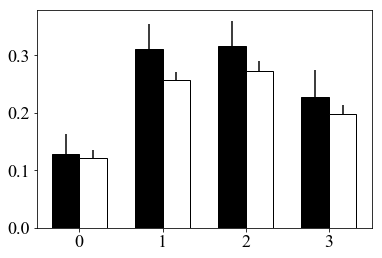

In [53]:
fig, ax = plt.subplots()
ax.bar(np.arange(4)-0.33/2, raiguel_slope1_mean, yerr = raiguel_slope1_sem, color='k', width=0.33,ec='k', zorder=3)
ax.bar(np.arange(4)+0.33/2, raiguel_slope2_mean, yerr = raiguel_slope2_sem, color='w', width=0.33, ec='k', zorder=3)

(124L,)
(90L,)
                 df      sum_sq     mean_sq          F        PR(>F)
C(bin)          5.0  496.513233   99.302647  21.236456  4.783303e-17
train           1.0  347.009451  347.009451  74.210014  2.012830e-15
C(bin):train    5.0  124.712859   24.942572   5.334116  1.255293e-04
Residual      202.0  944.561321    4.676046        NaN           NaN
(112L,)
(98L,)
                 df      sum_sq    mean_sq          F        PR(>F)
C(bin)          5.0   97.715583  19.543117  27.825027  2.686442e-21
train           1.0   25.650811  25.650811  36.521018  7.373357e-09
C(bin):train    5.0   19.686693   3.937339   5.605889  7.427183e-05
Residual      198.0  139.066786   0.702358        NaN           NaN


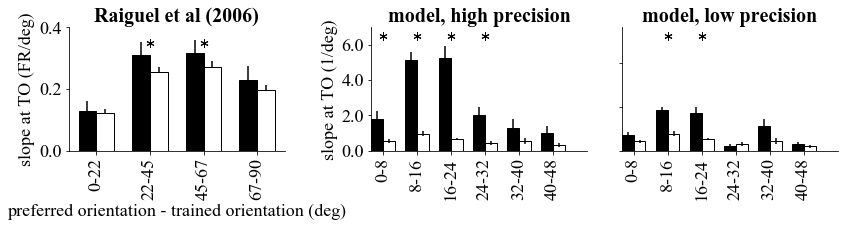

In [54]:
feat1 = 'ori'
feat2 = 'abs_grad'

bins = np.array([0,8,16,24,32,40,48])
#bins = np.array([0,22,45,67,90])

nbins = len(bins)-1

bin_centers = (bins[1:]+bins[:-1])/2.0
this_blobs = blobs[4:5]
this_diffs = [diffs[i] for i in [1,3]]
nblob = len(this_blobs)
ndiff = len(this_diffs)
xtickslabels = map(lambda x: '%.0f-%.0f' %(x[0],x[1]), np.c_[bins[:-1],bins[1:]])

fig, axes = plt.subplots(nblob, ndiff+1, figsize=(12,3.5))
axes = axes[None,:]

for di, diff in enumerate(this_diffs):
    _, idx = lookup(w_df, noise = 15.0, wave = 10.0, ctrst = 0.2, d_angle = diff)

    for bi, blob in enumerate(this_blobs):
        
        ax = axes[nblob-1-bi, di+1]

        all_feat1_vals = np.array([])
        all_feat2_vals = np.array([])

        for ii, i in enumerate(idx):
            A_common = np.where(dfs[i].A_common[blob])[0]
            feat1_vals = dfs[i].A.t[blob][feat1] - w_df['angle'].iloc[i]
            feat1_vals = feat1_vals[A_common]
            feat2_vals = dfs[i].A.t_test[blob][feat2][A_common]
            all_feat1_vals = np.r_[all_feat1_vals, feat1_vals]
            all_feat2_vals = np.r_[all_feat2_vals, feat2_vals]

        #ax.scatter(all_feat1_vals, all_feat2_vals, s=1, color = 'r', alpha = 0.3)    
        #ax.set_ylim([0,0.0013])
        _, _, trained_vals = scatter_errorbar(ax, np.abs(all_feat1_vals), (all_feat2_vals), bins, 
                                              lw=2.0, color='r',marker='o', fillstyle = 'none', plot=False);
        trained_mean = map(np.mean, trained_vals)
        trained_sem = map(sem, trained_vals)
        ax.bar(np.arange(nbins)-0.35/2, trained_mean, 0.35, yerr=trained_sem, fc='k', ec='k')


        print np.concatenate(trained_vals).shape
        all_feat1_vals = np.array([])
        all_feat2_vals = np.array([])
        for ii, i in enumerate(idx):
            B_common   = np.where(dfs[i].B_common[blob])[0]
            feat1_vals = dfs[i].B.t[blob][feat1] - w_df['angle'].iloc[i]
            feat1_vals = feat1_vals[B_common]
            feat2_vals = dfs[i].B.t_test[blob][feat2][B_common]
            all_feat1_vals = np.r_[all_feat1_vals, feat1_vals]
            all_feat2_vals = np.r_[all_feat2_vals, feat2_vals]

        #ax.scatter(all_feat1_vals, all_feat2_vals, s=1,color='k', alpha = 0.1)    
        _, _, untrained_vals = scatter_errorbar(ax, np.abs(all_feat1_vals), (all_feat2_vals), bins, 
                                                lw=2.0, color='b', ls = '--', marker='o', fillstyle = 'none', 
                                                plot=False);
        untrained_mean = map(np.mean, untrained_vals)
        untrained_sem = map(sem, untrained_vals)
        ax.bar(np.arange(nbins)+0.35/2, untrained_mean, 0.35, yerr=untrained_sem, fc='w', ec='k')
        
        print np.concatenate(untrained_vals).shape

        ax.set_ylim([0,7])
        ax.set_xlim([-0.35, nbins])
        ax.set_xticks(range(nbins))
        ax.set_xticklabels(xtickslabels, rotation=90)
        
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        cool_spines(ax)

        slope_df = pd.DataFrame(columns=['slope','bin', 'train'])
        for bini in range(nbins):
            slope_df = slope_df.append(pd.DataFrame(dict(bin=bini, slope=untrained_vals[bini], train=0)))
            slope_df = slope_df.append(pd.DataFrame(dict(bin=bini, slope=trained_vals[bini], train=1)))
        model = ols('slope ~ C(bin) * (train)', data = slope_df).fit()
        #print model.summary()
        print sm.stats.anova_lm(model)
        
        if sm.stats.anova_lm(model)['PR(>F)'].loc['C(bin):train'] < 0.01:
            for bini in range(nbins):
                F_value, p_value = mannwhitneyu(trained_vals[bini], untrained_vals[bini])
                if p_value < 0.01/7:
                    ax.plot([bini], [6.5], marker=(6,2,0), color = 'k', ms=8)

axes[0,1].set_title('model, high precision',  weight='bold', fontsize=20)
axes[0,2].set_title('model, low precision',  weight='bold', fontsize=20)
axes[0,0].set_ylabel('slope at TO (FR/deg)')
axes[0,1].set_ylabel('slope at TO (1/deg)')
axes[0,-1].set_yticklabels([])
axes[0,1].set_yticks(np.arange(0.0,8.1,2.0))
axes[0,1].set_yticklabels(np.arange(0.0,8.1,2.0))
axes[0,1].set_ylim([0,7])
axes[0,2].set_ylim([0,7])



ax = axes[0,0]
ax.bar(np.arange(4)-0.33/2, raiguel_slope1_mean, yerr = raiguel_slope1_sem, color='k', width=0.33,ec='k', zorder=3)
ax.bar(np.arange(4)+0.33/2, raiguel_slope2_mean, yerr = raiguel_slope2_sem, color='w', width=0.33, ec='k', zorder=3)
ax.set_title('Raiguel et al (2006)', fontsize=20, weight='bold')
cool_spines(ax)
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['0-22', '22-45', '45-67', '67-90'], rotation=90)
ax.plot([1,2],[0.35,0.35],'*k', marker=(6,2,0),ms=8)
ax.set_xlabel('preferred orientation - trained orientation (deg)')
ax.set_ylim([0,0.4])

fig.tight_layout()
ax_width = 0.25
ax_poses= [0.08,ax_width,0.43,ax_width, 0.72, ax_width]
for i in range(3):
    ax_pos = list(axes[0,i].get_position().bounds)
    ax_pos[0] = ax_poses[i*2]
    ax_pos[2] = ax_poses[i*2+1]
    axes[0,i].set_position(ax_pos)
        
#fig.savefig(fig_dir + 'slope_TO_high.svg', dpi = 1000)

In [55]:
def test_dist(blob, diff, all_feat1_vals, all_feat2_vals, 
              all_feat1_common, all_feat2_common, 
              text_coords, test_text=None):

    test_pv = dict()
    print 'layer ' + blob[-1], 'diff: ', diff
    print 'nt= %d, nn = %d, nc = %d\n' % (len(all_feat1_vals), len(all_feat2_vals), len(all_feat1_common))
    
    U, pv = mannwhitneyu(all_feat1_vals, all_feat2_vals)
    print 'U:\n%.2f\n%.2f\n%.3g\n%.3g\n' % (np.median(all_feat2_vals), 
                                        np.median(all_feat1_vals),
                                        U, pv) 
    test_pv['U'] = pv
    d, pv = ks_2samp(all_feat1_vals, all_feat2_vals)
    print 'KS\n%.2g\n%.3g\n' % (d, pv)
    test_pv['ks']=pv
    
    Tv, pv = wilcoxon(all_feat1_common, all_feat2_common)
    print 'W\n%.2f\n%.2f\n%.3g\n%.3g\n' % (np.median(all_feat2_common), 
                                        np.median(all_feat1_common),
                                        Tv, pv) 
    test_pv['W']=pv

    tv, pv = ttest_ind(all_feat1_vals, all_feat2_vals)
    print 't:\n%.2f±%.2f\n%.2f±%.2f\n%.1f\n%.2g\n' % (all_feat2_vals.mean(), 
                                                all_feat2_vals.std(),
                                                all_feat1_vals.mean(),
                                                all_feat1_vals.std(),
                                                tv, pv)
    test_pv['t']=pv

    tv, pv = ttest_rel(all_feat1_common, all_feat2_common)
    print 't2\n%.2f±%.2f\n%.2f±%.2f\n%.3g\n%.2g\n' % (all_feat2_common.mean(), 
                                                all_feat2_common.std(),
                                                all_feat1_common.mean(),
                                                all_feat1_common.std(),
                                                tv, pv)
    test_pv['t2']=pv
    if test_text is not None:
        if 0.0001<test_pv[test_text] < 0.01:
            ax.text(text_coords[0], text_coords[1], '$p=%.2g$' % test_pv[test_text], transform=ax.transAxes)
        elif test_pv[test_text] < 0.0001:
            ax.text(text_coords[0], text_coords[1], '$p<0.0001$' % test_pv[test_text], transform=ax.transAxes)


## V4 preferred ori

Figure 5,

Raiguel, S., Vogels, R., Mysore, S. G., & Orban, G. a. (2006). Learning to see the difference specifically alters the most informative V4 neurons. The Journal of Neuroscience : The Official Journal of the Society for Neuroscience, 26(24), 6589–6602. https://doi.org/10.1523/JNEUROSCI.0457-06.2006

In [56]:
scale = 25/636.0
raiguel_po_dist1 =np.array([147, 185, 376, 460, 346,352,504, 338, 149])
raiguel_po_dist1 = (657-raiguel_po_dist1) * scale
raiguel_po_dist1 = np.roll(raiguel_po_dist1,-2)

raiguel_po_dist2 =np.array([232,411,342,384,276,422,385,281,232])
raiguel_po_dist2 = (657-raiguel_po_dist2) * scale
raiguel_po_dist2 = np.roll(raiguel_po_dist2,-2)

<Container object of 9 artists>

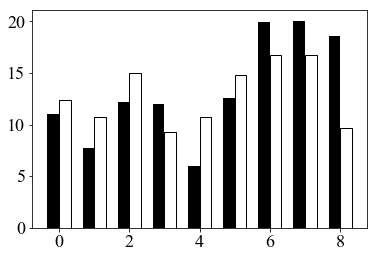

In [57]:
fig, ax = plt.subplots()
ax.bar(np.arange(9)-0.33/2, raiguel_po_dist1, width=0.33, color='k')
ax.bar(np.arange(9)+0.33/2, raiguel_po_dist2, width=0.33, color='w', ec='k')

d(295)=0.21, p=5.2e-12, 192
X(1,14)=
81.42
1.5e-11

d(222)=0.12, p=0.0029, 192
X(1,14)=
28.62
0.012



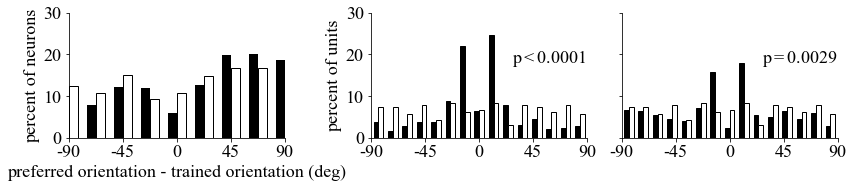

In [58]:
nbins = 16
bins = np.linspace(-90.0,90.0,nbins)
bin_centers = (bins[1:]+bins[:-1])/2.0
this_blobs = blobs[4:5]
this_diffs = [diffs[i] for i in [1,3]]
nblob = len(this_blobs)
ndiff = len(this_diffs)

bar_colors = ['w' for _ in range(nbins-1)]
bar_colors[nbins/2-1] = 'k'
offset = 180.0 / (nbins-1) / 3
feat1 = 'ori'
feat2 = 'abs_grad'

fig, axes = plt.subplots(nblob, ndiff+1, figsize=(12,3), sharex = True)
axes = axes[None,:]

for di, diff in enumerate(this_diffs):
    _, idx = lookup(w_df, noise = 15.0, wave = 10.0, ctrst = 0.2, d_angle = diff)

    for bi, blob in enumerate(this_blobs):
        
        ax = axes[nblob-1-bi, di+1]
        
        all_feat1_vals = np.array([])
        for ii, i in enumerate(idx):
            ori = dfs[i].A.t[blob]['mean']
            feat1_vals = dfs[i].A.t[blob]['ori'] - w_df['angle'].iloc[i]

            all_feat1_vals = np.r_[all_feat1_vals, feat1_vals]

        counts = np.histogram(all_feat1_vals, bins)[0].astype('float')
        trained_counts = counts.copy()
        
        ax.bar(bin_centers - offset/2, counts/counts.sum()*100, 
               color = 'k', align='center', ec='k',
               linewidth = 1, width = offset)
            
        all_feat2_vals = np.array([])
        for ii, i in enumerate(idx):
            ori = dfs[i].B.t[blob]['mean']
            feat2_vals = dfs[i].B.t[blob]['ori'] - w_df['angle'].iloc[i]

            all_feat2_vals = np.r_[all_feat2_vals, feat2_vals]

        counts = np.histogram(all_feat2_vals, bins)[0].astype('float')
        untrained_counts = counts.copy()
        ax.bar(bin_centers + offset/2, counts/counts.sum()*100, 
               facecolor = 'w', width = offset,align='center', ec='k',)
        #ax.plot([-diff, -diff],[0,0.25], ':k')
        #ax.plot([diff, diff],[0,0.25], ':k')
        d_value, pv = kstest(all_feat1_vals, 'uniform', args=(-90,180))
        print 'd(%d)=%.2g, p=%.2g, %d' % (len(all_feat1_vals), d_value, pv, len(all_feat2_vals))
        if pv <0.0001:
            ax.text(0.65, 0.6, '$p< 0.0001$' % pv, transform=ax.transAxes)
        elif pv < 0.01:
            ax.text(0.65, 0.6, '$p=%.4f$' % pv, transform=ax.transAxes)

            
        x2, pv = chi2_contingency(np.c_[untrained_counts, trained_counts])[:2]
        print 'X(1,%d)=\n%.4g\n%.2g' % (nbins-2, x2, pv)
        print ''
        
        ax.set_ylim([0,25])
        ax.set_xlim([-90,90])
        ax_xticks(ax, [-90,-45,0,45,90], [-90,-45,0,45,90])
        ax.set_yticks(range(0,31,10))
        cool_spines(ax)

        
axes[0,-1].set_yticklabels([])
ax = axes[0,0]
ax.set_xlabel('preferred orientation - trained orientation (deg)')
ax.set_ylabel('percent of neurons')
ax.bar((np.arange(9)-0.33/2)*22.5-90, raiguel_po_dist1, width=0.33*22.5, color='k')
ax.bar((np.arange(9)+0.33/2)*22.5-90, raiguel_po_dist2, width=0.33*22.5, color='w', ec='k')
ax.set_xlim(-90,90)
cool_spines(ax)
ax.set_yticks(range(0,31,10))
axes[0,1].set_ylabel('percent of units')

fig.tight_layout()
ax_width = 0.26
for i in range(3):
    ax_pos = list(axes[0,i].get_position().bounds)
    ax_pos[0] = ax_poses[i*2]
    ax_pos[2] = ax_poses[i*2+1]
    axes[0,i].set_position(ax_pos)
fig.savefig(fig_dir + 'prefer_ori_dist_high.svg', dpi = 1000)

## Selectivity Index of V4

Figure 3,

Raiguel, S., Vogels, R., Mysore, S. G., & Orban, G. a. (2006). Learning to see the difference specifically alters the most informative V4 neurons. The Journal of Neuroscience : The Official Journal of the Society for Neuroscience, 26(24), 6589–6602. https://doi.org/10.1523/JNEUROSCI.0457-06.2006

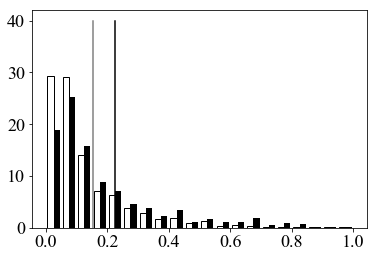

In [59]:
raiguel_si_hist = 493 - np.array([[147, 266],
                                   [148, 191],
                                   [327, 303],
                                   [410, 386],
                                   [419, 408],
                                   [447, 439],
                                   [459, 447],
                                   [472, 465],
                                   [470, 452],
                                   [482, 479],
                                   [478, 473],
                                   [490, 479], 
                                   [486, 479], 
                                   [490, 471], 
                                   [492, 487],
                                   [492, 482],
                                   [492, 484],
                                   [492, 490],
                                   [492, 491], 
                                   [492, 491]])
raiguel_si_hist = raiguel_si_hist*scale
raiguel_si_hist1 = raiguel_si_hist[:,1]/raiguel_si_hist[:,1].sum()*100
raiguel_si_hist2 = raiguel_si_hist[:,0]/raiguel_si_hist[:,0].sum()*100
raiguel_si_mean1 = 193/853.0
raiguel_si_mean2 = 131/853.0
raiguel_si_x = np.arange(0.0, 0.951, 0.05) + 0.05/2
fig, ax = plt.subplots()
ax.bar(raiguel_si_x-0.05*0.4/2.0, raiguel_si_hist2, color='w', ec='k', width=0.05*0.4)
ax.plot([raiguel_si_mean1,raiguel_si_mean1], [0,40],'k')
ax.bar(raiguel_si_x+0.05*0.4/2.0, raiguel_si_hist1, color='k', width=0.05*0.4)
ax.plot([raiguel_si_mean2,raiguel_si_mean2], [0,40],'gray')


layer 5 diff:  1.0
nt= 295, nn = 192, nc = 170

U:
0.55
0.75
2.11e+04
1.11e-06

KS
0.31
3.13e-10

W
0.53
0.55
4.16e+03
1.3e-06

t:
0.50±0.34
0.66±0.28
5.6
3.5e-08

t2
0.46±0.33
0.54±0.30
5.61
8.3e-08

X(1,18)=
135.5
4.7e-20

layer 5 diff:  5.0
nt= 222, nn = 192, nc = 189

U:
0.55
0.58
1.98e+04
0.0998

KS
0.14
0.0314

W
0.54
0.46
8.7e+03
0.71

t:
0.50±0.34
0.55±0.33
1.5
0.15

t2
0.50±0.34
0.51±0.33
1.01
0.31

X(1,18)=
84.4
1.4e-10



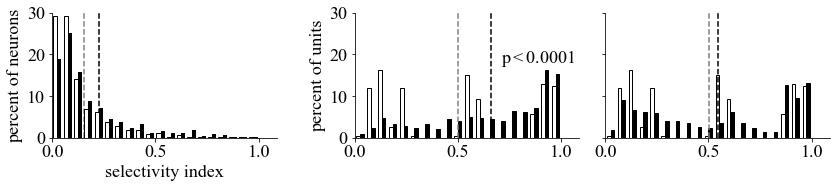

In [60]:
nbins = 20
bins = np.linspace(0,1,nbins)
bin_centers = (bins[1:]+bins[:-1])/2.0
this_blobs = blobs[4:5]
this_diffs = [diffs[i] for i in [1,3]]
nblob = len(this_blobs)
ndiff = len(this_diffs)

bar_colors = ['w' for _ in range(nbins-1)]
bar_colors[nbins/2-1] = 'k'
offset = 1.0 / (nbins-1) / 3
feat1 = 'mean'

fig, axes = plt.subplots(nblob, ndiff+1, figsize=(12,3), sharex = True)
axes = axes[None,:]

for di, diff in enumerate(this_diffs):
    _, idx = lookup(w_df, noise = 15.0, wave = 10.0, ctrst = 0.2, d_angle = diff)

    for bi, blob in enumerate(this_blobs):
        
        ax = axes[nblob-1-bi, di+1]

        all_feat1_vals = np.array([])
        feat1_common = np.array([], dtype='bool')
        for ii, i in enumerate(idx):
            fr = dfs[i].A.t[blob]['mean']
            SI = ((np.sin(2*angles*np.pi/180.0).dot(fr))**2 + (np.cos(2*angles*np.pi/180.0).dot(fr))**2)
            SI = np.sqrt(SI)/fr.sum(0)
            feat1_vals = SI
            #feat1_vals = feat1_vals[dfs[i].A_common[blob]]
            feat1_common = np.r_[feat1_common, dfs[i].A_common[blob]]
            all_feat1_vals = np.r_[all_feat1_vals, feat1_vals]

        #ax.scatter(all_feat1_vals, all_feat2_vals, s=1, color = 'r', alpha = 0.3)    
        #ax.set_ylim([0,0.0013])
        counts = np.histogram(all_feat1_vals, bins)[0].astype('float')
        ax.bar(bin_centers+offset/2, counts/counts.sum()*100, align = 'center', color = 'k', width = offset/1,
              ec='k')
        untrained_counts = counts.copy()

        all_feat2_vals = np.array([])
        feat2_common = np.array([], dtype='bool')
        for ii, i in enumerate(idx):
            fr = dfs[i].B.t[blob]['mean']
            SI = ((np.sin(2*angles*np.pi/180.0).dot(fr))**2 + (np.cos(2*angles*np.pi/180.0).dot(fr))**2)
            SI = np.sqrt(SI)/fr.sum(0)
            feat2_vals = SI
            #feat2_vals = feat2_vals[dfs[i].B_common[blob]]
            feat2_common = np.r_[feat2_common, dfs[i].B_common[blob]]
            all_feat2_vals = np.r_[all_feat2_vals, feat2_vals]

        counts = np.histogram(all_feat2_vals, bins)[0].astype('float')
        trained_counts = counts.copy()

        ax.bar(bin_centers-offset/2, counts/counts.sum()*100, color = 'w', align = 'center', width = offset/1
              , ec='k')
        ax.plot([np.mean(all_feat1_vals), np.mean(all_feat1_vals)],[0,30], color = 'k',ls='--')
        ax.plot([np.mean(all_feat2_vals), np.mean(all_feat2_vals)],[0,30], color = 'gray',ls='--')        
        all_feat1_common = all_feat1_vals[feat1_common]
        all_feat2_common = all_feat2_vals[feat2_common]

        test_dist(blob, diff, all_feat1_vals, all_feat2_vals, 
              all_feat1_common, all_feat2_common, 
              [0.65,0.6], 'U')
        x2, pv = chi2_contingency(np.c_[untrained_counts, trained_counts]+0.01)[:2]
        print 'X(1,%d)=\n%.1f\n%.2g' % (nbins-2, x2, pv)   # number of bins = nbins-1
        print '============'
        print ''
        ax.set_xlim([0,1+offset*5])
        ax.set_ylim([0,30])
        ax.set_yticks([0,10,20,30])
        cool_spines(ax)
       
axes[0,1].set_ylabel('percent of units')
axes[0,-1].set_yticklabels([])

ax = axes[0,0]
ax.bar(raiguel_si_x-0.05*0.4/2.0, raiguel_si_hist2, color='w', ec='k', width=0.05*0.4)
ax.plot([raiguel_si_mean1,raiguel_si_mean1], [0,40],'k',ls='--', zorder=0)
ax.bar(raiguel_si_x+0.05*0.4/2.0, raiguel_si_hist1, color='k', width=0.05*0.4)
ax.plot([raiguel_si_mean2,raiguel_si_mean2], [0,40],'gray',ls='--',  zorder=0)
ax.set_xlabel('preferred orientation - trained orientation (deg)')
ax.set_xlabel('selectivity index')
ax.set_ylim([0,3])
ax.set_yticks([0,10,20,30])


cool_spines(ax)
axes[0,0].set_ylabel('percent of neurons')

fig.tight_layout()
ax_width = 0.26
ax_poses= [0.08,ax_width,0.43,ax_width, 0.72, ax_width]
for i in range(3):
    ax_pos = list(axes[0,i].get_position().bounds)
    ax_pos[0] = ax_poses[i*2]
    ax_pos[2] = ax_poses[i*2+1]
    axes[0,i].set_position(ax_pos)
#fig.savefig(fig_dir + 'SI_dist_high.svg', dpi = 1000)

## Fano 

Table 2 and Fig 3

Raiguel, S., Vogels, R., Mysore, S. G., & Orban, G. a. (2006). Learning to see the difference specifically alters the most informative V4 neurons. The Journal of Neuroscience : The Official Journal of the Society for Neuroscience, 26(24), 6589–6602. http://doi.org/10.1523/JNEUROSCI.0457-06.2006


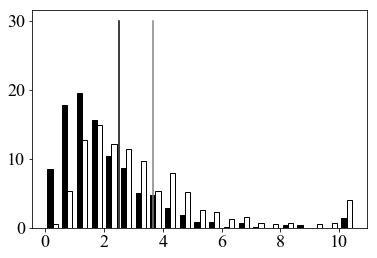

In [61]:
scale = 25.0/455
raiguel_fano_hist = 469.0 - np.array([
                                    [312, 460],
                                    [142, 371],
                                    [110, 238],
                                    [184, 199],
                                    [278, 248],
                                    [311, 261],
                                    [376, 292],
                                    [382, 372],
                                    [417, 325],
                                    [435, 374],
                                    [453, 421],
                                    [453, 428],
                                    [466, 447],
                                    [456, 440],
                                    [466, 456],
                                    [469, 460],
                                    [462, 457],
                                    [462, 469],
                                    [469, 460],
                                    [469, 457],
                                    [444, 397]])

raiguel_fano_hist1 = raiguel_fano_hist[:,0]/ raiguel_fano_hist[:,0].sum()*100
raiguel_fano_hist2 = raiguel_fano_hist[:,1]/ raiguel_fano_hist[:,1].sum()*100
raiguel_fano_mean1 = 206/817.0*10
raiguel_fano_mean2 = 300/817.0*10

raiguel_fano_x = np.arange(0.0, 10.1, 0.5) + 0.5/2
fig, ax = plt.subplots()
ax.bar(raiguel_fano_x+0.5*0.35/2.0, raiguel_fano_hist2, color='w', ec='k', width=0.5*0.35)
ax.plot([raiguel_fano_mean2,raiguel_fano_mean2],[0,30],'gray')
ax.bar(raiguel_fano_x-0.5*0.35/2.0, raiguel_fano_hist1, color='k', ec='k', width=0.5*0.35)
ax.plot([raiguel_fano_mean1,raiguel_fano_mean1],[0,30],'k')

layer 5 diff:  1.0
nt= 295, nn = 192, nc = 170

U:
0.45
0.22
1.58e+04
6.51e-17

KS
0.38
1.29e-15

W
0.42
0.18
1.37e+03
4.59e-20

t:
0.52±0.38
0.31±0.27
-7.2
1.8e-12

t2
0.47±0.33
0.28±0.28
-8.98
5e-16

X(1,19)=
89.0
p=4.9e-11
layer 5 diff:  5.0
nt= 222, nn = 192, nc = 189

U:
0.45
0.34
1.75e+04
0.000833

KS
0.2
0.000301

W
0.45
0.33
4.3e+03
5.21e-10

t:
0.52±0.38
0.43±0.33
-2.6
0.01

t2
0.52±0.39
0.42±0.32
-6
1e-08

X(1,19)=
28.6
p=0.073


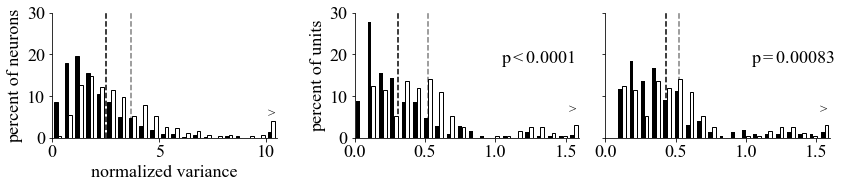

In [62]:
feat1 = 'mean_var'
nbins = 21
bins = np.linspace(0.0,1.6,nbins)
bin_centers = (bins[1:]+bins[:-1])/2.0
bins[-1] = np.inf

this_blobs = blobs[4:5]
this_diffs = [diffs[i] for i in [1,3]]
nblob = len(this_blobs)
ndiff = len(this_diffs)
offset = 1.6/(nbins-1)/3

fig, axes = plt.subplots(nblob, ndiff+1, figsize=(12,3))
axes = axes[None,:]

for di, diff in enumerate(this_diffs):
    _, idx = lookup(w_df, noise = 15.0, wave = 10.0, ctrst = 0.2, d_angle = diff)

    for bi, blob in enumerate(this_blobs):
        
        ax = axes[0, di+1]

        all_feat1_vals = np.array([])
        feat1_common = np.array([], dtype='bool')
        for ii, i in enumerate(idx):

            ori = dfs[i].A.t[blob]['ori'] - w_df['angle'].iloc[i]
            pref_idx = np.argmax(angles[:,None] > ori, axis=0)
            feat1_vals = 1/(dfs[i].A.t[blob][feat1][pref_idx, np.arange(len(pref_idx))])
            feat1_common = np.r_[feat1_common, dfs[i].A_common[blob]]

            all_feat1_vals = np.r_[all_feat1_vals, feat1_vals]
        #all_feat1_vals = all_feat1_vals[all_feat1_vals<1000]
        #all_feat1_vals[all_feat1_vals>100] = 100

        #ax.scatter(all_feat1_vals, all_feat2_vals, s=1, color = 'r', alpha = 0.3)    
        #ax.set_ylim([0,0.0013])
        counts = np.histogram(all_feat1_vals, bins)[0].astype('float')
        trained_counts = counts.copy()
        ax.bar(bin_centers-offset/2, counts/counts.sum()*100, color = 'k', width = offset)

        all_feat2_vals = np.array([])
        feat2_common = np.array([], dtype='bool')
        for ii, i in enumerate(idx):

            ori = dfs[i].B.t[blob]['ori'] - w_df['angle'].iloc[i]
            pref_idx = np.argmax(angles[:,None] > ori, axis=0)
            feat2_vals = 1/(dfs[i].B.t[blob][feat1][pref_idx, np.arange(len(pref_idx))])            
            feat2_common = np.r_[feat2_common, dfs[i].B_common[blob]]
            all_feat2_vals = np.r_[all_feat2_vals, feat2_vals]
        
        #all_feat1_vals = all_feat1_vals[all_feat1_vals<1000]
        #all_feat2_vals[all_feat2_vals>100] = 100
        
        counts = np.histogram(all_feat2_vals, bins)[0].astype('float')
        untrained_counts = counts.copy()
        ax.bar(bin_centers + offset/2, counts/counts.sum()*100, color = 'w', width = offset, ec='k')
        ax.plot([np.mean(all_feat1_vals),np.mean(all_feat1_vals)], [0,30], color = 'k' ,ls='--', zorder=0)
        ax.plot([np.mean(all_feat2_vals),np.mean(all_feat2_vals)], [0,30], color = 'gray' ,ls='--', zorder=0)
        cool_spines(ax)
        
        all_feat1_common = all_feat1_vals[feat1_common]
        all_feat2_common = all_feat2_vals[feat2_common]
        test_dist(blob, diff, all_feat1_vals, all_feat2_vals, 
              all_feat1_common, all_feat2_common, 
              [0.65,0.6], 'U')   
        x2, pv = chi2_contingency(np.c_[untrained_counts+1, trained_counts+1])[:2]
        print 'X(1,%d)=\n%.1f\np=%.2g' % (nbins-2, x2, pv)   # number of bins = nbins-1
        print '============='
            
        ax.set_xlim([-0.0,bins[-2]*1.05])
        ax.set_ylim([0,30])
        ax.text(1.55, 6,'>',ha='center',fontsize=13)
        #ax_xticks(ax,range(), range(6))
ax_yticks(axes[0,1], np.arange(0,31,10), np.arange(0,31,10))
axes[0,-1].set_yticklabels([])        
axes[0,1].set_ylabel('percent of units')

ax = axes[0,0]
ax.bar(raiguel_fano_x+0.5*0.35/2.0, raiguel_fano_hist2, color='w', ec='k', width=0.5*0.35)
ax.plot([raiguel_fano_mean2,raiguel_fano_mean2],[0,30],'gray',ls='--', zorder=0)
ax.bar(raiguel_fano_x-0.5*0.35/2.0, raiguel_fano_hist1, color='k', ec='k', width=0.5*0.35)
ax.plot([raiguel_fano_mean1,raiguel_fano_mean1],[0,30],'k',ls='--', zorder=0)
ax.set_xlabel('normalized variance')
ax.set_xlim([-0.0,10.5])
ax.text(10.25, 5,'>',ha='center',fontsize=13)
ax.set_ylim([0,30])
ax_yticks(axes[0,1], np.arange(0,31,10), np.arange(0,31,10))


cool_spines(ax)
axes[0,0].set_ylabel('percent of neurons')

fig.tight_layout()
ax_width = 0.26
ax_poses= [0.08,ax_width,0.43,ax_width, 0.72, ax_width]
for i in range(3):
    ax_pos = list(axes[0,i].get_position().bounds)
    ax_pos[0] = ax_poses[i*2]
    ax_pos[2] = ax_poses[i*2+1]
    axes[0,i].set_position(ax_pos)
#fig.savefig(fig_dir + 'fano_dist_high.svg', dpi = 1000)

In [63]:
sg.Figure("18cm", "18.1cm",
       sg.Panel(
          sg.SVG(fig_dir+'slope_TO_high.svg').move(0,10).scale(0.8),
          sg.Text("A", 10, 15, size=15, weight='bold'),
          sg.Text("B", 270, 15, size=15, weight='bold'),
          ),
       sg.Panel(
          sg.SVG(fig_dir+'prefer_ori_dist_high.svg').scale(0.8),
          sg.Text("C", 10, 10, size=15, weight='bold'),
          sg.Text("D", 270, 10, size=15, weight='bold'),
          ).move(0, 200),
       sg.Panel(
          sg.SVG(fig_dir+'SI_dist_high.svg').move(0,10).scale(0.8),
          sg.Text("E", 10, 15, size=15, weight='bold'),
          sg.Text("F", 270, 15, size=15, weight='bold'),
          ).move(0,360),
       sg.Panel(
          sg.SVG(fig_dir+'fano_dist_high.svg').move(0,10).scale(0.8),
          sg.Text("G", 10, 15, size=15, weight='bold'),
          sg.Text("H", 270, 15, size=15, weight='bold'),
          ).move(0,520),
          
).save(fig_dir+"fig_8.svg")
display(SVG(fig_dir+'fig_8.svg'))

## Max firing rate
Table 2 in 

Raiguel, S., Vogels, R., Mysore, S. G., & Orban, G. a. (2006). Learning to see the difference specifically alters the most informative V4 neurons. The Journal of Neuroscience : The Official Journal of the Society for Neuroscience, 26(24), 6589–6602. http://doi.org/10.1523/JNEUROSCI.0457-06.2006


## Tuning amplitude
Table 1 and fig 5 in 

Yang, T., & Maunsell, J. H. (2004). The effect of perceptual learning on neuronal responses in monkey visual area V4. J.Neurosci., 24(1529-2401), 1617–1626. http://doi.org/10.1523/JNEUROSCI.4442-03.2004

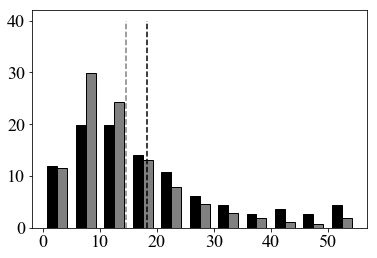

In [66]:
scale = 40.0/515
yang_ta_dist1 = 602.0-np.array([448,345,345,419,461,522,545,568,556,568,545])
yang_ta_dist2 = 1233.0-np.array([1084,848,919,1065,1132,1174,1195,1208,1218,1223,1209])
yang_ta_dist1 /= yang_ta_dist1.sum()/100
yang_ta_dist2 /= yang_ta_dist2.sum()/100
yang_ta_mean1 = 289/790.0*50
yang_ta_mean2 = 229/790.0*50
yang_ta_x = np.arange(2.5,55,5)

fig, ax = plt.subplots()
ax.bar(yang_ta_x-5*0.7/4, yang_ta_dist1, width=0.7*5/2, fc='k', ec='k')
ax.plot([yang_ta_mean1,yang_ta_mean1], [0,40], '--k')
ax.bar(yang_ta_x+5*0.7/4, yang_ta_dist2, width=0.7*5/2, fc='gray', ec='k')
ax.plot([yang_ta_mean2,yang_ta_mean2], [0,40], 'gray', ls='--')

layer 5 diff:  1.0
nt= 295, nn = 192, nc = 170

U:
14.64
22.09
1.9e+04
4.16e-10

KS
0.38
4.48e-15

W
14.83
34.11
450
2.74e-26

t:
17.30±7.59
31.02±25.63
7.2
2.3e-12

t2
17.99±7.75
40.31±28.69
11.1
9.5e-22

layer 5 diff:  5.0
nt= 222, nn = 192, nc = 189

U:
14.64
18.88
1.62e+04
1.45e-05

KS
0.22
5e-05

W
14.65
20.66
1.19e+03
4.58e-25

t:
17.30±7.59
21.90±11.67
4.7
4.3e-06

t2
17.41±7.60
23.42±11.71
9.82
1.2e-18



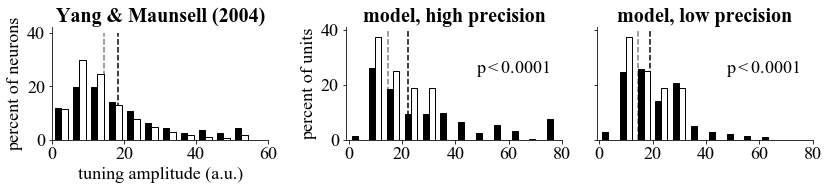

In [67]:
feat1 = 'mean'
nbins = 13
bins = np.linspace(0.0,80.0,nbins)
bin_centers = (bins[1:]+bins[:-1])/2.0
this_blobs = blobs[4:5]
this_diffs = [diffs[i] for i in [1,3]]
nblob = len(this_blobs)
ndiff = len(this_diffs)
offset = bins[-1]/(nbins-1)/3
bins[-1]=np.inf

fig, axes = plt.subplots(nblob, ndiff+1, figsize=(12,3))
axes = axes[None,:]

for di, diff in enumerate(this_diffs):
    _, idx = lookup(w_df, noise = 15.0, wave = 10.0, ctrst = 0.2, d_angle = diff)

    for bi, blob in enumerate(this_blobs):
        
        ax = axes[nblob-1-bi, di+1]
        axes[nblob-1-bi, 0].set_ylabel(blob)

        feat1_common = np.array([], dtype='bool')
        all_feat1_vals = np.array([])
        for ii, i in enumerate(idx):
            feat1_vals = dfs[i].A.t[blob]['mean'].ptp(0)
            feat1_common = np.r_[feat1_common, dfs[i].A_common[blob]]
            all_feat1_vals = np.r_[all_feat1_vals, feat1_vals]

        #ax.scatter(all_feat1_vals, all_feat2_vals, s=1, color = 'r', alpha = 0.3)    
        #ax.set_ylim([0,0.0013])
        counts = np.histogram(all_feat1_vals, bins)[0].astype('float')
        ax.bar(bin_centers-offset/2, counts/counts.sum()*100, color='k', width = offset, ec='k')

        feat2_common = np.array([], dtype='bool')
        all_feat2_vals = np.array([])
        for ii, i in enumerate(idx):
            feat2_vals = dfs[i].B.t[blob]['mean'].ptp(0)
            feat2_common = np.r_[feat2_common, dfs[i].B_common[blob]]
            all_feat2_vals = np.r_[all_feat2_vals, feat2_vals]

        counts = np.histogram(all_feat2_vals, bins)[0].astype('float')
        ax.bar(bin_centers+offset/2, counts/counts.sum()*100, color = 'w', width = offset, ec='k')
        
        # tests
        all_feat1_common = all_feat1_vals[feat1_common]
        all_feat2_common = all_feat2_vals[feat2_common]
        
        test_dist(blob, diff, all_feat1_vals, all_feat2_vals, 
              all_feat1_common, all_feat2_common, 
              [0.6,0.6], 'U')
        ax.set_xlim([-1,80])
        ax.set_ylim(0,41)
        ax_yticks(ax, np.arange(0,41,20), np.arange(0,41,20))
        ax_xticks(ax, np.arange(0,81,20), np.arange(0,81,20))
        
        ax.plot([np.median(all_feat1_vals)]*2, [0.0,40], '--', color = 'k', zorder=0)
        ax.plot([np.median(all_feat2_vals)]*2, [0.0,40], '--', color = 'gray', zorder=0)
        cool_spines(ax)
   

axes[0,1].set_title('model, high precision', fontsize=20, weight='bold')
axes[0,2].set_title('model, low precision', fontsize=20, weight='bold')
axes[0,0].set_xlabel('tuning amplitude (a.u.)')
axes[0,0].set_ylabel('percent of neurons')
axes[0,1].set_ylabel('percent of units')

axes[0,-1].set_yticklabels([])

ax=axes[0,0]
ax.bar(yang_ta_x-5*0.7/4, yang_ta_dist1, width=0.7*5/2, fc='k', ec='k')
ax.plot([yang_ta_mean1,yang_ta_mean1], [0,40], '--k', zorder=0)
ax.bar(yang_ta_x+5*0.7/4, yang_ta_dist2, width=0.7*5/2, fc='w', ec='k')
ax.plot([yang_ta_mean2,yang_ta_mean2], [0,40], 'gray', ls='--', zorder=0)
cool_spines(ax)
ax.set_xlim([0,60])
fig.tight_layout()
ax_width = 0.25
ax_poses= [0.08,ax_width,0.42,ax_width, 0.71, ax_width]
for i in range(3):
    ax_pos = list(axes[0,i].get_position().bounds)
    ax_pos[0] = ax_poses[i*2]
    ax_pos[2] = ax_poses[i*2+1]
    axes[0,i].set_position(ax_pos)
ax.set_title('Yang & Maunsell (2004)', fontsize=20, weight='bold')
#fig.savefig(fig_dir + 'amp_dist_high.svg', dpi = 1000)

## Best discriminability

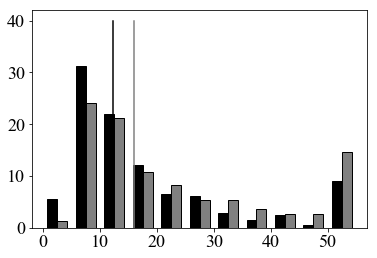

In [68]:
scale = 40.0/349
yang_bd_dist1 = 392.0-np.array([342,115,198,285,334,338,367,378,370,387,312])
yang_bd_dist2 = 839.0-np.array([828,634,659,748,768,793,793,808,817,817,715])
yang_bd_dist1 *=100/yang_bd_dist1.sum()
yang_bd_dist2 *=100/yang_bd_dist2.sum()
yang_bd_mean1 = 130/533.0*50
yang_bd_mean2 = 170/533.0*50
yang_bd_x = np.arange(2.5,55,5)

fig, ax = plt.subplots()
ax.bar(yang_bd_x-5*0.7/4, yang_bd_dist1, width=0.7*5/2, fc='k', ec='k')
ax.plot([yang_bd_mean1,yang_bd_mean1], [0,40], 'k')
ax.bar(yang_bd_x+5*0.7/4, yang_bd_dist2, width=0.7*5/2, fc='gray', ec='k')
ax.plot([yang_bd_mean2,yang_bd_mean2], [0,40], 'gray')

In [69]:
1/np.max(dfs[i].A.t[blob]['mean']/dfs[i].A.t[blob]['var'],0)

array([ 0.29130007,  0.26668505,  0.21849402,  0.41050006,  0.18948756,
        1.14523038,  0.12633317,  0.12306531,  0.1257411 ,  0.46605532,
        0.65003776,  0.17203524,  0.53481021,  0.5376185 ,  0.2414678 ,
        0.11099268,  1.15801048,  0.603338  ,  0.39432891])

layer 5 diff:  1.0
nt= 295, nn = 192, nc = 170

U:
0.80
0.11
9.48e+03
1.14e-35

KS
0.51
1.81e-27

W
0.83
0.17
1.12e+03
1.08e-21

t:
1.02±0.80
0.31±0.46
-12.3
1.7e-30

t2
1.06±0.81
0.36±0.44
-11
1.5e-21

layer 5 diff:  5.0
nt= 222, nn = 192, nc = 189

U:
0.80
0.55
1.76e+04
0.00113

KS
0.2
0.000573

W
0.82
0.64
6.39e+03
0.000582

t:
1.02±0.80
0.84±0.87
-2.1
0.037

t2
1.03±0.80
0.91±0.90
-1.82
0.07



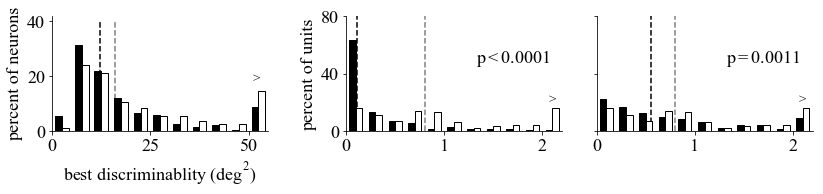

In [71]:
feat1 = 'mean'
nbins = 12
bins = np.linspace(0.0,2.2,nbins)
bin_centers = (bins[1:]+bins[:-1])/2.0
this_blobs = blobs[4:5]
this_diffs = [diffs[i] for i in [1,3]]
nblob = len(this_blobs)
ndiff = len(this_diffs)
offset = bins.max()/(nbins-1)/3
bins[-1]=np.inf

fig, axes = plt.subplots(nblob, ndiff+1, figsize=(12,3))
axes = axes[None,:]

for di, diff in enumerate(this_diffs):
    _, idx = lookup(w_df, noise = 15.0, wave = 10.0, ctrst = 0.2, d_angle = diff)

    for bi, blob in enumerate(this_blobs):
        
        ax = axes[nblob-1-bi, di+1]
        axes[nblob-1-bi, 0].set_ylabel(blob)

        all_feat1_vals = np.array([])
        feat1_common = np.array([], dtype='bool')
        for ii, i in enumerate(idx):
            feat1_vals = 1/np.max(dfs[i].A.t[blob]['abs_grad']**2/dfs[i].A.t[blob]['var'],0)
            feat1_common = np.r_[feat1_common, dfs[i].A_common[blob]]
            all_feat1_vals = np.r_[all_feat1_vals, feat1_vals]

        #ax.scatter(all_feat1_vals, all_feat2_vals, s=1, color = 'r', alpha = 0.3)    
        #ax.set_ylim([0,0.0013])
        counts = np.histogram(all_feat1_vals, bins)[0].astype('float')
        ax.bar(bin_centers-offset/2, counts/counts.sum()*100, color='k', width = offset, ec='k')

        all_feat2_vals = np.array([])
        feat2_common = np.array([], dtype='bool')
        for ii, i in enumerate(idx):
            feat2_vals = 1/np.max(dfs[i].B.t[blob]['abs_grad']**2/dfs[i].B.t[blob]['var'],0)
            feat2_common = np.r_[feat2_common, dfs[i].B_common[blob]]
            all_feat2_vals = np.r_[all_feat2_vals, feat2_vals]

        counts = np.histogram(all_feat2_vals, bins)[0].astype('float')
        ax.bar(bin_centers+offset/2, counts/counts.sum()*100, color = 'w', width = offset, ec='k')
        
        all_feat1_common = all_feat1_vals[feat1_common]
        all_feat2_common = all_feat2_vals[feat2_common]
        test_dist(blob, diff, all_feat1_vals, all_feat2_vals, 
              all_feat1_common, all_feat2_common, 
              [0.6, 0.6], 'U')
        ax.set_xlim([0,2.2])
        ax.text(2.1, 20,'>',ha='center',fontsize=13)

        ax.set_ylim(0,80)
        ax_yticks(ax, np.arange(0.0,81,40), np.arange(0,81,40))
        cool_spines(ax)
        
        ax.plot([np.median(all_feat1_vals)]*2, [0.0,80], '--', color = 'k', zorder=0)
        ax.plot([np.median(all_feat2_vals)]*2, [0.0,80], '--', color = 'gray', zorder=0)

axes[0,0].set_xlabel('best discriminablity (deg$^2$)')
axes[0,0].set_ylabel('percent of neurons')
axes[0,1].set_ylabel('percent of units')
axes[0,-1].set_yticklabels([])


ax=axes[0,0]
ax.bar(yang_bd_x-5*0.7/4, yang_bd_dist1, width=0.7*5/2, fc='k', ec='k')
ax.plot([yang_bd_mean1,yang_bd_mean1], [0,40], '--k', zorder=0)
ax.bar(yang_bd_x+5*0.7/4, yang_bd_dist2, width=0.7*5/2, fc='w', ec='k')
ax.plot([yang_bd_mean2,yang_bd_mean2], [0,40], 'gray', ls='--', zorder=0)
ax.text(52, 18,'>',ha='center',fontsize=13)
ax.set_xlim([0,55])
ax.set_xticks([0,25,50])

cool_spines(ax)
fig.tight_layout()
ax_width = 0.26
for i in range(3):
    ax_pos = list(axes[0,i].get_position().bounds)
    ax_pos[0] = ax_poses[i*2]
    ax_pos[2] = ax_poses[i*2+1]
    axes[0,i].set_position(ax_pos)
#fig.savefig(fig_dir + 'best_d_dist_high.svg', dpi = 1000)

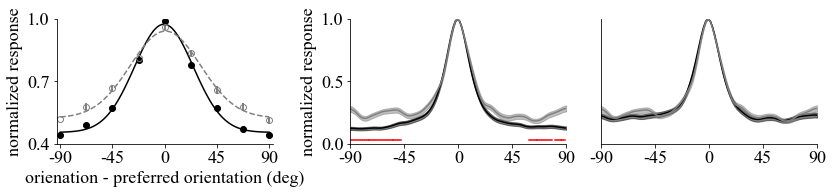

In [72]:
this_blobs = blobs[4:5]
this_diffs = [diffs[i] for i in [1,3]]
nblob = len(this_blobs)
ndiff = len(this_diffs)

fig, axes = plt.subplots(nblob, ndiff+1, figsize=(12,3))
axes = axes[None,:]


for di, diff in enumerate(this_diffs):
    _, idx = lookup(w_df, noise = 15.0, wave = 10.0, ctrst = 0.2, d_angle = diff)

    for bi, blob in enumerate(this_blobs):
        
        ax = axes[nblob-1-bi, di+1]
        axes[nblob-1-bi, 0].set_ylabel(blob)
        
        all_feat1_vals = np.zeros((nangle, 0))
        for ii, i in enumerate(idx):

            ori = dfs[i].A.t[blob]['ori'] - w_df['angle'].iloc[i]
            pref_idx = np.argmax(angles[:,None] > ori, axis=0)
            tc = dfs[i].A.t[blob]['mean'].copy()
            
            for ni in range(tc.shape[1]):
                tc[:,ni] = np.roll(tc[:,ni],50-pref_idx[ni])/tc[:,ni].max()

            all_feat1_vals = np.c_[all_feat1_vals, tc]

        plot_env(ax, angles, all_feat1_vals.mean(1), all_feat1_vals.std(1), 
                std_scale=np.sqrt(all_feat1_vals.shape[1]), color='k')
    
        all_feat2_vals = np.zeros((nangle, 0))
        for ii, i in enumerate(idx):

            ori = dfs[i].B.t[blob]['ori'] - w_df['angle'].iloc[i]
            pref_idx = np.argmax(angles[:,None] > ori, axis=0)
            tc = dfs[i].B.t[blob]['mean'].copy()
            
            for ni in range(tc.shape[1]):
                tc[:,ni] = np.roll(tc[:,ni],50-pref_idx[ni])/tc[:,ni].max()

            all_feat2_vals = np.c_[all_feat2_vals, tc]

        plot_env(ax, angles, all_feat2_vals.mean(1), all_feat2_vals.std(1), 
                std_scale=np.sqrt(all_feat2_vals.shape[1]), color='gray')

        # tests
        cool_spines(ax)
        ax_xticks(ax, [-90,-45,0,45,90], [-90,-45,0,45,90])
        ax.set_ylim([0,1])
        ax.set_yticks([0,0.5,1.0])
        
        prefer_nonprefer = np.c_[all_feat1_vals[25:75,:].mean(0), all_feat1_vals.sum(0)-all_feat1_vals[25:75,:].mean(0)]
        tuning_df1 = pd.melt(pd.DataFrame(prefer_nonprefer), var_name='angle', value_name='tuning')
        tuning_df1['train']=1

        
        prefer_nonprefer = np.c_[all_feat2_vals[25:75,:].mean(0), all_feat2_vals.sum(0)-all_feat2_vals[25:75,:].mean(0)]
        tuning_df2 = pd.melt(pd.DataFrame(prefer_nonprefer), var_name='angle', value_name='tuning')
        tuning_df2['train']=0

        tuning_df = pd.concat([tuning_df1, tuning_df2])

        model = ols('tuning ~ C(angle) * C(train)', data = tuning_df).fit()
        anova_table = sm.stats.anova_lm(model)
        
        if anova_table['PR(>F)']['C(angle):C(train)']<0.01:
            for i in range(99):
                if mannwhitneyu(all_feat1_vals[i], all_feat2_vals[i], alternative='less')[1]<0.01/100:
                    ax.plot([angles[i]-0.5,angles[i]+0.5],[0.03,0.03],color='r')
        ax.set_xlim([-90,90])

axes[0,0].set_xlabel('orienation - preferred orientation (deg)')
axes[0,0].set_ylabel('normalized response')
axes[0,1].set_ylabel('normalized response')

ax = axes[0,0]
from scipy.optimize import curve_fit

scale = 1.0/692
yang_tc_x = np.arange(-90,91,22.5)
yang_tc1_mean = (773 - np.array([467,434,379,219,89, 234, 378, 447,467]))*scale
yang_tc2_mean = (773 - np.array([415,374, 312, 213, 107, 195, 317, 374,419]))*scale
yang_tc2_sem = (np.array([0.0,23,21,0.0,23,23,25,25,22]))*scale

ax.plot(yang_tc_x, yang_tc1_mean, marker='o', lw=0, color='k')
ax.errorbar(yang_tc_x, yang_tc2_mean,yerr=yang_tc2_sem/2.0,  marker='o', lw=0, fillstyle='none', color='gray', elinewidth=2.0)
ax.set_yticks([0.4,0.7,1.0])

def gauss(x, *p):
    A, mu, sigma, b = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))+b

# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
p0 = [1., 0., 20.,0.5]
coeff, var_matrix = curve_fit(gauss, yang_tc_x, yang_tc1_mean, p0=p0)
# Get the fitted curve
hist_fit = gauss(angles, *coeff)
ax.plot(angles, hist_fit, 'k')
ax_xticks(ax, [-90,-45,0,45,90], [-90,-45,0,45,90])

coeff, var_matrix = curve_fit(gauss, yang_tc_x, yang_tc2_mean, p0=p0)
# Get the fitted curve
hist_fit = gauss(angles, *coeff)
ax.errorbar(angles, hist_fit, color='gray',ls='--')
ax.set_ylim([0.4,1.0])
axes[0,-1].set_yticks([])
cool_spines(ax)
ax.set_xlim([-93,93])


fig.tight_layout()
ax_width = 0.26
for i in range(3):
    ax_pos = list(axes[0,i].get_position().bounds)
    ax_pos[0] = ax_poses[i*2]
    ax_pos[2] = ax_poses[i*2+1]
    axes[0,i].set_position(ax_pos)
    
#fig.savefig(fig_dir + 'pop_tc_high.svg', dpi = 1000)

In [73]:
sg.Figure("18cm", "13.3cm",
       sg.Panel(
          sg.SVG(fig_dir+'amp_dist_high.svg').move(0,10).scale(0.8),
          sg.Text("A", 10, 15, size=15, weight='bold'),
          sg.Text("B", 250, 15, size=15, weight='bold'),
          ),
       sg.Panel(
          sg.SVG(fig_dir+'best_d_dist_high.svg').scale(0.8),
          sg.Text("C", 10, 5, size=15, weight='bold'),
          sg.Text("D", 250, 5, size=15, weight='bold'),
          ).move(0, 170),
       sg.Panel(
          sg.SVG(fig_dir+'pop_tc_high.svg').scale(0.8),
          sg.Text("E", 10, 5, size=15, weight='bold'),
          sg.Text("F", 250, 5, size=15, weight='bold'),
          ).move(0, 340),
          
).save(fig_dir+"fig_9.svg")
display(SVG(fig_dir+'fig_9.svg'))